## Portfolio: US Counties Poverty Rate Regression Modeling ##
This is data science portfolio based on real dataset to predict povert rate acorss the United States at the country level using socio-economic indicators. The dataset was compiled from wide range of sources and publicly made available by United States Department of Agriculture Economic Research Service (USDA ERS). It can be found here https://datasciencecapstone.org/competitions/3/county-poverty/page/10/.

** Problem Statement: ** 
In US, being poverty is defined as having an income below a federally defined poverty threshold. This represents US federal government's estimation of how many families are below in which their income levels do not meet any basic needs (i.e., food, shelter, clothing and other essential goods). Thus, our goal is to make predictions on poverty rates by counties within US in order to make recommendations for federal government agencies. This will help them to initiate and implement policies/support the families below officially defined poverty thresholds.

The US poverty rate dataset contains 33 features in total. There are 30 numerical and 3 categorical features to predict one target variable (i.e., poverty_rate). There are 4 different kinds of information are available from this dataset which includes county's urbanization degree (development level), economic indicators, health indicators and demographic indicators. 

** Stakeholders: ** 
US federal policy makers, counties' representatives and other Not-For-Profit (NFP) organizations.

** Goal: **
To make accurate predictions on US counties' poverty rate with minimum root-mean-squared-errors (RMSEs).

** Results: ** 
Using feature selection techniques (L1, L2, Feature Importance), best combination of features were
selected to train each model. By feeding the best 12 features selected from L1/L2, the polynomial regression was a top performer. The modeld reported **RMSE: 3.01** and **R^2: 0.794** on a test set.


** Risks: ** With visual inspection from residual and quantile plots, there were some errors for making accurate predictions. Especially, from lower and upper range of poverty rate of counties were deviated a lot from predictions.

** Mitigation: ** 
Review these identified errors and outliers with subject matter experts before making any implementation or policy changes to improve poverty rates across US counties.

** Future Work: **
1. Model improvements: feasibility of testing other ensemble models, stacking and neural network.
2. Data collection/refinement: integrate with other financial and job market related data sources 
    * Household income by counties 
    * Job market trends by counties
    * KPIs related to accessibility for basic needs (i.e., food, housing, etc.)

** Recommendation for clients: ** 
1. ** Support economic development plan for nonmetro counties. ** A lot of nonmetro counties with population less than 2,000 characterized by no specialized industries and government fund dependent were in higher poverty rates. Thus, it is important for federal and state government agencies to help them establish their own specialized industries (i.e., tourism, agricultural and etc.) for resolving higher poverty rates.

2. ** Maintain good transportation infrastructure and urban planning for nonmetro counties. ** Combined effects of large population size and adjacency to metro area showed lower poverty rates. Usually, the bigger and well developed urban counties tend to have huge pool of job openings. Thus, lower poverty rates were observed in comparison to counties located far from metro area.

## Part A. Data Wrangling ##
Original dataset was loaded onto Python as a dataframe. Dataset presented with a couple of problems such as missing data and outliers. Thus, data cleaning and transformation processes were performed in a following order: feature imputation --> handling outliers --> format metadata types --> feature transformation (i.e., feature encoding).

In [1]:
# Import all libraries #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import sklearn.metrics as skm
import scipy.stats as sp
import pylab 

#############################################
# Load training dataset for US poverty rate #
#############################################
df = pd.read_csv('PP_train.csv')

######################
# Data Quality Check #
######################
# Missing value dataframe:
PP_missing = df.isnull().sum()
PP_missing = pd.DataFrame(PP_missing)
# Rename column as missing value counts:
PP_missing.columns = ['counts']

# Compute missing value percent:
PP_missing['missing_pct'] = PP_missing['counts']/len(df)
PP_missing = PP_missing.sort_values(by='missing_pct', ascending=False)
PP_missing['missing_pct']

C:\Users\yoots\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


health__homicides_per_100k                          0.615072
health__pct_excessive_drinking                      0.305816
health__pct_adult_smoking                           0.145091
health__motor_vehicle_crash_deaths_per_100k         0.130394
health__pop_per_dentist                             0.076298
health__pop_per_primary_care_physician              0.071920
health__pct_low_birthweight                         0.056911
health__air_pollution_particulate_matter            0.008755
demo__pct_hispanic                                  0.000625
demo__pct_american_indian_or_alaskan_native         0.000625
health__pct_diabetes                                0.000625
health__pct_physical_inacticity                     0.000625
demo__pct_asian                                     0.000625
health__pct_adult_obesity                           0.000625
demo__pct_non_hispanic_white                        0.000625
demo__pct_non_hispanic_african_american             0.000625
demo__pct_aged_65_years_

#### Compute Summary Statistics: Pre Data Cleaning ####

In [2]:
# Print summary statistics: poverty_rate
df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,3198.0,3156.692620,1823.959278,0.000000,1561.750000,3198.500000,4723.750000,6277.000000
econ__pct_civilian_labor,3198.0,0.467071,0.074541,0.217000,0.420000,0.467000,0.514000,1.000000
econ__pct_unemployment,3198.0,0.059610,0.022850,0.008000,0.044000,0.057000,0.071000,0.240000
econ__pct_uninsured_adults,3196.0,0.217534,0.067372,0.046000,0.166000,0.216000,0.262000,0.495000
econ__pct_uninsured_children,3196.0,0.085920,0.040005,0.009000,0.057000,0.077000,0.105000,0.285000
demo__pct_female,3196.0,0.498781,0.024251,0.294000,0.493000,0.503000,0.512000,0.576000
demo__pct_below_18_years_of_age,3196.0,0.227763,0.034291,0.098000,0.207000,0.226000,0.245250,0.417000
demo__pct_aged_65_years_and_older,3196.0,0.170137,0.043594,0.043000,0.142000,0.167000,0.194000,0.355000
demo__pct_hispanic,3196.0,0.090233,0.142707,0.000000,0.019000,0.035000,0.088000,0.945000
demo__pct_non_hispanic_african_american,3196.0,0.091117,0.147104,0.000000,0.006000,0.022000,0.096250,0.855000


#### Data Quality Check #1: drop negative value observation(s) ####

In [3]:
# Print indexes where negative values occurred on 'health_homicides_per_100k':
df[df['health__homicides_per_100k'] < 0].index

# Drop negative value observations:
df = df.drop(df.index[[87, 830, 954, 1282, 1402, 1994]])

# Check number of observations where less than 0 on 'health_homicides_per_100k':
np.bincount(df['health__homicides_per_100k'] < 0)

array([3192], dtype=int64)

#### Data Quality Check #2: drop any feature(s) where missing values > 50% (threshold) ####

In [4]:
# Drop a feature missing more than 50%:
df = df.drop(['health__homicides_per_100k'], axis=1)
# Check data types and missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3192 entries, 0 to 3197
Data columns (total 34 columns):
row_id                                              3192 non-null int64
area__rucc                                          3192 non-null object
area__urban_influence                               3192 non-null object
econ__economic_typology                             3192 non-null object
econ__pct_civilian_labor                            3192 non-null float64
econ__pct_unemployment                              3192 non-null float64
econ__pct_uninsured_adults                          3190 non-null float64
econ__pct_uninsured_children                        3190 non-null float64
demo__pct_female                                    3190 non-null float64
demo__pct_below_18_years_of_age                     3190 non-null float64
demo__pct_aged_65_years_and_older                   3190 non-null float64
demo__pct_hispanic                                  3190 non-null float64
demo__pct_

In [5]:
# Compute summary statistics: 
df_stat = df.describe().T
df_stat = df_stat[['count', 'min', 'max', 'mean', 'std', '25%', '50%', '75%']]
df_stat = df_stat.sort_values(by='count', ascending=True)
df_stat

,count,min,max,mean,std,25%,50%,75%
health__pct_excessive_drinking,2214.0,0.038000,0.358000,0.164696,0.050201,0.129000,0.164000,0.196000
health__pct_adult_smoking,2728.0,0.050000,0.526000,0.213649,0.063092,0.171000,0.211000,0.250000
health__motor_vehicle_crash_deaths_per_100k,2775.0,3.090000,110.450000,21.146022,10.508196,13.500000,19.640000,26.490000
health__pop_per_dentist,2948.0,339.000000,28129.000000,3435.677069,2570.313782,1819.750000,2694.500000,4092.500000
health__pop_per_primary_care_physician,2962.0,189.000000,23400.000000,2554.429440,2101.457358,1422.250000,1999.500000,2859.000000
health__pct_low_birthweight,3010.0,0.025000,0.232000,0.083564,0.022392,0.068000,0.080000,0.095000
health__air_pollution_particulate_matter,3164.0,7.000000,15.000000,11.626422,1.545641,10.000000,12.000000,13.000000
health__pct_diabetes,3190.0,0.033000,0.197000,0.109339,0.023185,0.094000,0.109000,0.124000
health__pct_physical_inacticity,3190.0,0.097000,0.443000,0.277446,0.052900,0.243000,0.280000,0.313000
demo__pct_asian,3190.0,0.000000,0.346000,0.013255,0.025340,0.003000,0.007000,0.013000


#### Data Quality Check #3: handling outliers for accurate regression modeling ####

Outliers are the values that might potentialy skew the results on our modeling. In order to maximize the performance of classification model(s), it is required to handle outliers first. In a training set, there are 30 numerical features and a outlier detection dataframe was created. In general, it was easy to identify there were outlier(s) in "distance" and "avg. income". The maximum value on each of feature is greater than the upper bound value computed IQR method.

Outliers were required to be managed properly on these numerical features. In a training set, there were 10 independent features (i.e., continuous). These included “avg_income”, “distance” and etc. Interquartile range (IQR) method applied here. For example, if any value of a feature sits below lower and above upper bounds of IQR, these observations will be removed from dataset.

IQR is defined as: **IQR = Q3 – Q1** in which Q3 is 75th percentile and Q1 is 25th percentile of a feature. **Lower bound (LB) equals to Q1 – (1.5 x IQR)** and **upper bound (UB) equals to Q3 + (1.5 x IQR).**

From above definition, summary table was computed on all three numerical features.

In [6]:
# Compute IQR, LB, UB:
df_stat['IQR'] = df_stat['75%'] - df_stat['25%']
df_stat['LB'] = df_stat['25%'] - 1.5*df_stat['IQR']
df_stat['UB'] = df_stat['75%'] + 1.5*df_stat['IQR']

# Create poverty_rate outliers dataframe:
df_outliers = df_stat[['LB', 'min', 'UB', 'max']]
df_outliers

,LB,min,UB,max
health__pct_excessive_drinking,0.028500,0.038000,0.296500,0.358000
health__pct_adult_smoking,0.052500,0.050000,0.368500,0.526000
health__motor_vehicle_crash_deaths_per_100k,-5.985000,3.090000,45.975000,110.450000
health__pop_per_dentist,-1589.375000,339.000000,7501.625000,28129.000000
health__pop_per_primary_care_physician,-732.875000,189.000000,5014.125000,23400.000000
health__pct_low_birthweight,0.027500,0.025000,0.135500,0.232000
health__air_pollution_particulate_matter,5.500000,7.000000,17.500000,15.000000
health__pct_diabetes,0.049000,0.033000,0.169000,0.197000
health__pct_physical_inacticity,0.138000,0.097000,0.418000,0.443000
demo__pct_asian,-0.012000,0.000000,0.028000,0.346000


In [7]:
# Check # of features with outliers from LowerBound P.O.V:
print(df_outliers['LB'] > df_outliers['min'])
np.count_nonzero(df_outliers['LB'] > df_outliers['min'])

# Check # of features with outliers from UpperBound P.O.V:
print(df_outliers['UB'] < df_outliers['max'])
np.count_nonzero(df_outliers['UB'] < df_outliers['max'])

health__pct_excessive_drinking                      False
health__pct_adult_smoking                            True
health__motor_vehicle_crash_deaths_per_100k         False
health__pop_per_dentist                             False
health__pop_per_primary_care_physician              False
health__pct_low_birthweight                          True
health__air_pollution_particulate_matter            False
health__pct_diabetes                                 True
health__pct_physical_inacticity                      True
demo__pct_asian                                     False
demo__pct_american_indian_or_alaskan_native         False
demo__pct_non_hispanic_white                         True
demo__pct_non_hispanic_african_american             False
demo__pct_hispanic                                  False
demo__pct_aged_65_years_and_older                    True
demo__pct_below_18_years_of_age                      True
demo__pct_female                                     True
econ__pct_unin

27

#### Remove Outliers ####
Test how many observations are treated as outliers based on LB or UB perspective. This is very critical since while removing outliers, we want to maintain balanced sample size for building an accurate regression model.

In [8]:
# Count how many outliers were from LB or UB perspectives on different features #
# UpperBound P.O.V:
print(df[df['health__pct_excessive_drinking'] > df_outliers.loc['health__pct_excessive_drinking']['UB']].index.shape)
print(df[df['health__pct_adult_smoking'] > df_outliers.loc['health__pct_adult_smoking']['UB']].index.shape)
print(df[df['health__motor_vehicle_crash_deaths_per_100k'] > df_outliers.loc['health__motor_vehicle_crash_deaths_per_100k']['UB']].index.shape)
print(df[df['health__pop_per_dentist'] > df_outliers.loc['health__pop_per_dentist']['UB']].index.shape)
print(df[df['health__pop_per_primary_care_physician'] > df_outliers.loc['health__pop_per_primary_care_physician']['UB']].index.shape)

# LowerBound P.O.V:
print(df[df['health__pct_adult_smoking'] < df_outliers.loc['health__pct_adult_smoking']['LB']].index.shape)
print(df[df['health__pct_low_birthweight'] < df_outliers.loc['health__pct_low_birthweight']['LB']].index.shape)

# Drop UB outliers from primary_care_physician: 242 rows
df = df.drop(df[df['health__pop_per_primary_care_physician'] > df_outliers.loc['health__pop_per_primary_care_physician']['UB']].index)

(13,)
(49,)
(69,)
(196,)
(242,)
(1,)
(1,)


#### Feature Encoding ####
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female).

**Ordinal feature encoding:** area_rucc and area_urban_influence. 
area_rucc is a feature where it has a order classified by population size of counties by degree of urbanization. Thus, area_rucc gets mapped into numerical values. Same goes for area_urban_influence where it has a natural order by size of counties and proximity to metro and micropolitan areas. For checking format of data consistency, we will print transformed features.

In [9]:
# Define manual mapping for area__rucc:
###############################################################################
urban_deg_map ={'Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area': 1,
        'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area': 1,
        'Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area': 2,
        'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area': 2,
        'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area': 3,
        'Nonmetro - Urban population of 20,000 or more, adjacent to a metro area': 3,
        'Metro - Counties in metro areas of fewer than 250,000 population': 4,
        'Metro - Counties in metro areas of 250,000 to 1 million population': 5,
        'Metro - Counties in metro areas of 1 million population or more': 6}

# Use deg_urban_map to transform the area__rucc into ordinal integers:
df['area__rucc'] = df['area__rucc'].map(urban_deg_map)
print(df['area__rucc'].head())

# Transform integer value back to original string
###############################################################################
inv_urban_deg_map = {v:k for k, v in urban_deg_map.items()}
#df['area__rucc'] = df['area__rucc'].map(inv_urban_deg_map)

# Define manual mapping for area__urban_influence:
###############################################################################
urban_size_map ={'Noncore adjacent to a small metro and does not contain a town of at least 2,500 residents': 1,
               'Noncore adjacent to a small metro with town of at least 2,500 residents': 2,
               'Noncore not adjacent to a metro/micro area and does not contain a town of at least 2,500 residents': 3,
               'Noncore not adjacent to a metro/micro area and contains a town of 2,500  or more residents': 4,
               'Noncore adjacent to micro area and contains a town of 2,500-19,999 residents': 5,
               'Noncore adjacent to a large metro area': 6,
               'Micropolitan not adjacent to a metro area': 7,
               'Micropolitan adjacent to a small metro area': 8,
               'Micropolitan adjacent to a large metro area': 9,
               'Small-in a metro area with fewer than 1 million residents': 10,
               'Large-in a metro area with at least 1 million residents or more': 11}

# Use deg_urban_map to transform the area__rucc into ordinal integers:
df['area__urban_influence'] = df['area__urban_influence'].map(urban_size_map)
print(df['area__urban_influence'].head())

# Transform integer value back to original string
###############################################################################
inv_urban_size_map = {v:k for k, v in urban_size_map.items()}
#df['area__urban_influence'] = df['area__urban_influence'].map(inv_urban_size_map)

# Define manual mapping for yr:
###############################################################################
yr_map ={'a':'year 1', 'b':'year 2'}

# User yr_map to transform yr feature into ordinal strings:
df['yr'] = df['yr'].map(yr_map)
print(df['yr'].head())

1    2
2    1
3    2
4    6
5    2
Name: area__rucc, dtype: int64
1     9.0
2     5.0
3     5.0
4    11.0
5     7.0
Name: area__urban_influence, dtype: float64
1    year 2
2    year 2
3    year 2
4    year 1
5    year 1
Name: yr, dtype: object


####  Data Quality Check #4: Feature Imputation ####
Let's compute feature imputation to replace missing values by following:
* Mode: area__urban_influence
* Mean: health_pct_adult_smoking, excessive_drinking, ... ,health_pct_air_pollution (idx: 6-15, 22-29)
* Median: health_pop_dentist and health_pop_primary_care_physician will be replaced (idx: 30, 31)

** Note: ** how different set of features' missing values were replaced by different methods. 
* First, 'area__urban_influence' was a ordinal (categorical) feature. Thus, it makes sense to replace missing values by most frequently occurred value (mode). 
* Second, 'health_pct_adult_smoking', 'excessive_drinking', etc. were numerical features. Also these features showed normal distributions upon plotting histograms. Thus, these can be replaced by mean. 
* Finally, 'health_pop_dentist' and 'health_pop_primary_care_physician' were numerical features but they showed non-normal distributions (i.e., skewed). Thus, it was better to replace them by median instead of mean.

In [10]:
# Replacement via Mode #
########################
# area__urban_influence:
###############################################################################
df_urban_size_cnt = df['area__urban_influence'].value_counts().sort_values(ascending=False)
print(df_urban_size_cnt)
# counts=623, Mode = 10

# Replacement by mode: categorical features
df['area__urban_influence'] = df['area__urban_influence'].fillna(10)

# Split data into input features and target variable #
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# check input features:
print(X.head(), X.tail())

# check target variable: poverty_rate
print(y.head(), y.tail())

# Feature Imputation #
######################
# Imputation by mean: numeric features
# column indexes: 6-15, 22-29
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(X.iloc[:, 6:16])
X.iloc[:, 6:16] = imputer.transform(X.iloc[:, 6:16])

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputer = imputer.fit(X.iloc[:, 22:30])
X.iloc[:, 22:30] = imputer.transform(X.iloc[:, 22:30])

# Imputation by median: numeric features
# column indexes: 30-31 (health_pop_dentist & primary_care_physician)
imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
imputer = imputer.fit(X.iloc[:, 30:32]) # NOTE: index shift by 1 due to removing 'health_pct_homicides_per_100k'
X.iloc[:, 30:32] = imputer.transform(X.iloc[:, 30:32])

10.0    623
11.0    405
2.0     309
8.0     255
7.0     245
3.0     205
5.0     187
1.0     143
6.0     139
9.0     122
4.0     122
Name: area__urban_influence, dtype: int64
   row_id  area__rucc  area__urban_influence  \
1       2           2                    9.0   
2       4           1                    5.0   
3       5           2                    5.0   
4       8           6                   11.0   
5       9           2                    7.0   

              econ__economic_typology  econ__pct_civilian_labor  \
1             Manufacturing-dependent                     0.503   
2  Federal/State government-dependent                     0.471   
3  Federal/State government-dependent                     0.578   
4                      Nonspecialized                     0.530   
5                      Nonspecialized                     0.481   

   econ__pct_unemployment  econ__pct_uninsured_adults  \
1                   0.057                       0.171   
2                   

In [11]:
# create a cleaned df #
#######################
# concatenated cleaned inputs and output label:
df_cleaned = pd.concat([X, y], axis=1)

# check any missing values on cleaned df:
print(df_cleaned.isnull().sum())

# convert data types for correct metadata:
df_cleaned['row_id'] = df_cleaned['row_id'].astype(int)
df_cleaned['area__rucc'] = df_cleaned['area__rucc'].astype('category')
df_cleaned['area__urban_influence'] = df_cleaned['area__urban_influence'].astype('category')
df_cleaned['econ__economic_typology'] = df_cleaned['econ__economic_typology'].astype('category')
df_cleaned['yr'] = df_cleaned['yr'].astype('category')

# check cleaned dataframe: data types
df_cleaned.info()

row_id                                              0
area__rucc                                          0
area__urban_influence                               0
econ__economic_typology                             0
econ__pct_civilian_labor                            0
econ__pct_unemployment                              0
econ__pct_uninsured_adults                          0
econ__pct_uninsured_children                        0
demo__pct_female                                    0
demo__pct_below_18_years_of_age                     0
demo__pct_aged_65_years_and_older                   0
demo__pct_hispanic                                  0
demo__pct_non_hispanic_african_american             0
demo__pct_non_hispanic_white                        0
demo__pct_american_indian_or_alaskan_native         0
demo__pct_asian                                     0
demo__pct_adults_less_than_a_high_school_diploma    0
demo__pct_adults_with_high_school_diploma           0
demo__pct_adults_with_some_c

## Part B. Exploratory Data Analysis ##

#### US poverty rate by counties: training set ###
Data exploration is conducted on cleaned trainng set. The main goal of this phase is to explore any interesting relationships among features and identify which feature are good predictors on poverty rate predictions.

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tells a compelling story about the US poverty dataset.

In [12]:
# Copy dataframe for EDA:
df_EDA = df_cleaned.copy()

# Feature Scaling: multiply by 100 on percent features
# idx: 4:20, 22:28;
df_EDA.iloc[:, 4:20] = df_EDA.iloc[:, 4:20] * 100
df_EDA.iloc[:, 22:28] = df_EDA.iloc[:, 22:28] * 100

# Feature engineering: to create county class label feature #
#############################################################
# using a feature ['area__rucc']
# {1,2,3:'non-metro'}, {4,5,6:'metro'}
county_class_bins = [0,3,6]
county_class_labels = ['Nonmetro','Metro']

# Stratification: generate county class labels #
df_EDA['county_class'] = pd.cut(np.array(df['area__rucc']), bins=county_class_bins, labels=county_class_labels)

# Convert ordinal features back to categorical strings #
df_EDA['area__rucc'] = df_EDA['area__rucc'].map(inv_urban_deg_map)
df_EDA['area__urban_influence'] = df_EDA['area__urban_influence'].map(inv_urban_size_map)

In [13]:
# Perform summary statistics
df_EDA = df_EDA.drop(['row_id'],axis=1)
PP_summary = df_EDA.describe().T
PP_summary = PP_summary[['count','min','max','mean','std','25%','50%','75%']]

# Print summary stat:
PP_summary

,count,min,max,mean,std,25%,50%,75%
econ__pct_civilian_labor,2950.0,21.700000,100.000000,46.964271,7.449310,42.200000,47.000000,51.500000
econ__pct_unemployment,2950.0,0.800000,24.000000,5.908542,2.303993,4.300000,5.600000,7.100000
econ__pct_uninsured_adults,2950.0,4.600000,49.500000,21.576628,6.728794,16.400000,21.300000,26.100000
econ__pct_uninsured_children,2950.0,0.900000,28.500000,8.534871,4.020728,5.600000,7.650000,10.500000
demo__pct_female,2950.0,29.400000,57.600000,49.926662,2.377211,49.300000,50.400000,51.200000
demo__pct_below_18_years_of_age,2950.0,9.800000,41.700000,22.746710,3.453621,20.600000,22.600000,24.500000
demo__pct_aged_65_years_and_older,2950.0,4.300000,35.500000,17.049355,4.409493,14.200000,16.700000,19.500000
demo__pct_hispanic,2950.0,0.000000,94.500000,9.110719,14.229874,1.900000,3.600000,9.000000
demo__pct_non_hispanic_african_american,2950.0,0.000000,85.500000,8.689043,14.378876,0.600000,2.000000,8.900000
demo__pct_non_hispanic_white,2950.0,6.000000,99.800000,77.195251,20.741486,65.100000,85.600000,93.700000


### B0. Correlation Matrix: US Poverty Rate dataset ###

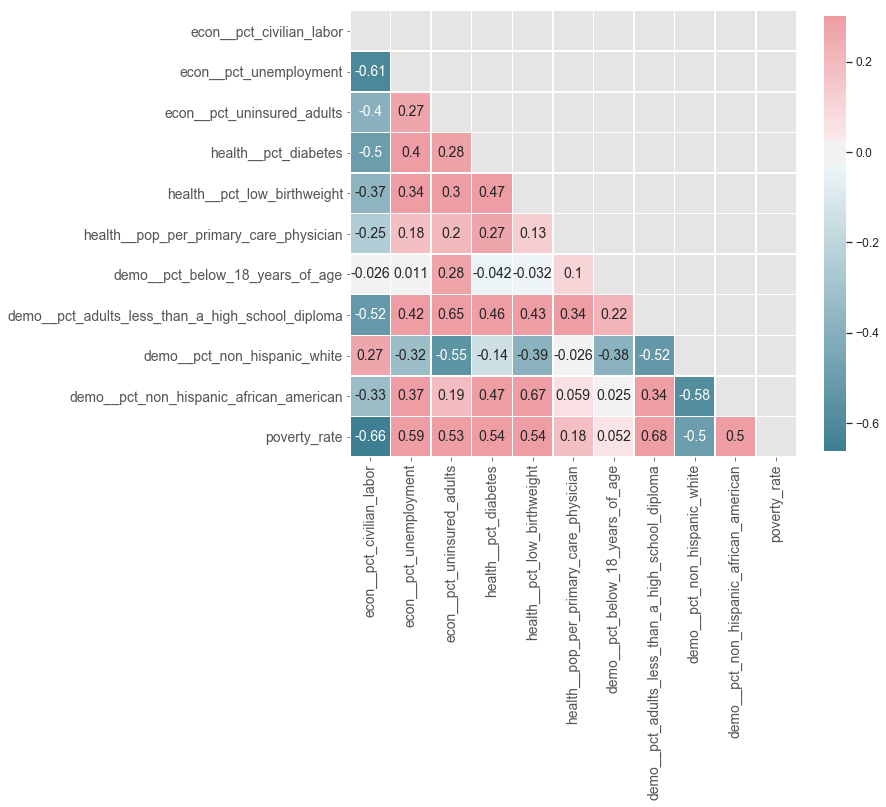

In [14]:
# Correlation matrix plot # 
###########################
# Correlation matrix dataframe: drop categoric
df_CM = df_EDA.drop(['area__rucc','area__urban_influence','econ__economic_typology', 'yr'], axis=1)

# Simplified version: 10 feaatures
df_CM_cut = df_EDA[['econ__pct_civilian_labor', 'econ__pct_unemployment', 'econ__pct_uninsured_adults', 
                    'health__pct_diabetes','health__pct_low_birthweight', 'health__pop_per_primary_care_physician',
                    'demo__pct_below_18_years_of_age','demo__pct_adults_less_than_a_high_school_diploma',
                    'demo__pct_non_hispanic_white', 'demo__pct_non_hispanic_african_american', 'poverty_rate']]

# Compute Correlation Matrix:
corr = df_CM_cut.corr()

# Create a mask to filter matrix: diagonally
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# CM Plot:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(font_scale=1.1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            annot=True, square=True, linewidths=.5,
            annot_kws={'size':14}, cbar_kws={"shrink": .8})
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.show()

**Summary: Correlation Matrix Plot**

In summary, positive correlations were observed between % unemployment rate, % diabetes, % low birthweight and etc. against poverty rate in US. On contrary, negative correlations were observed between % civilian labor, % Caucasian and % education with bachelor or higher against poverty rate in US.

Order of "Pearson's r" magintude from positive to negative correlation against poverty rate:
% unemployment rate > % low birthweight> % uninsured adults ... % excessive drinking > % education level > % civilian labor. 

In [15]:
# Compute the correlation of each feature against poverty rate: order of magnitude
PV_CM = df_CM.corr().sort_values(by=['poverty_rate'], ascending=False)['poverty_rate']
print(PV_CM)

poverty_rate                                        1.000000
demo__pct_adults_less_than_a_high_school_diploma    0.675136
econ__pct_unemployment                              0.592800
health__pct_low_birthweight                         0.539099
health__pct_diabetes                                0.535235
econ__pct_uninsured_adults                          0.534755
demo__pct_non_hispanic_african_american             0.500255
health__pct_adult_obesity                           0.435364
health__pct_physical_inacticity                     0.427547
health__motor_vehicle_crash_deaths_per_100k         0.386330
health__pct_adult_smoking                           0.371977
health__pop_per_dentist                             0.261272
demo__pct_american_indian_or_alaskan_native         0.251668
demo__death_rate_per_1k                             0.241783
demo__pct_adults_with_high_school_diploma           0.202645
health__pop_per_primary_care_physician              0.183519
demo__birth_rate_per_1k 

In [16]:
# Filter correlations between features above Pearson r > 0.5:
for x in corr.columns:
    for y in corr.columns:
        if x < y and corr[x][y] > abs(0.5):
            print(x, y, corr[x][y])

econ__pct_unemployment poverty_rate 0.592800222037
econ__pct_uninsured_adults poverty_rate 0.534755186644
health__pct_diabetes poverty_rate 0.535234733328
health__pct_low_birthweight poverty_rate 0.539099053155
demo__pct_adults_less_than_a_high_school_diploma econ__pct_uninsured_adults 0.654816667494
demo__pct_adults_less_than_a_high_school_diploma poverty_rate 0.675135720869
demo__pct_non_hispanic_african_american health__pct_low_birthweight 0.665954748683
demo__pct_non_hispanic_african_american poverty_rate 0.50025490483


### B1. Univariate Analysis: continuous numeric features (scale) ###

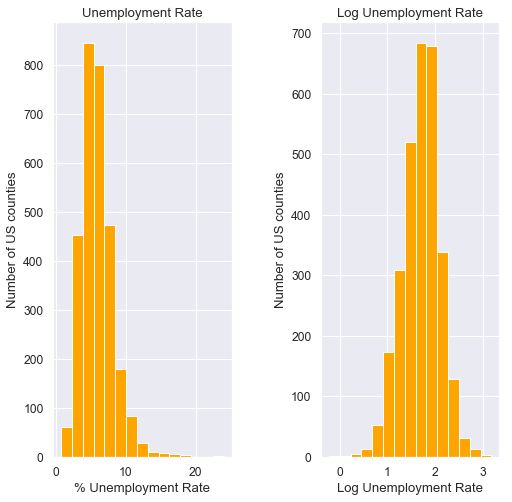

In [17]:
##############################################################################
# Univariate analysis: continuous features [scale]
##############################################################################
# fig 1: normal vs. log scale pct_unemployment # 
# Plot: normal pct_unemployment rate
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.subplot(1, 2, 1)
plt.hist(df_EDA.econ__pct_unemployment, color='orange', bins=15)
plt.title('Unemployment Rate')
plt.xlabel('% Unemployment Rate')
plt.ylabel('Number of US counties')

# Plot: log scale pct_unemployment rate
plt.subplot(1, 2, 2)
plt.hist(np.log(df_EDA.econ__pct_unemployment), color='orange', bins=15)
plt.title('Log Unemployment Rate')
plt.xlabel('Log Unemployment Rate')
plt.ylabel('Number of US counties')
plt.show()

** Summary: Effect of Log Transformation **

Histogram on the left with normal scale showed that distribution is skewed to right. Meaning that unemployment rate is relatively lower within most of US counties. Histogram on right showed log scale of unemployment rate distribution. Thus, applying log scale, distribution of unemployment rate became closer to normal distribution.

** Histogram Analyses: Economic Indicators **

In [18]:
# Write a function: plot 2by2 histogram subplots
def plot_hist_2by2(x1,b1,lab1,
                   x2,b2,lab2,
                   x3,b3,lab3,
                   x4,b4,lab4):
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Subplot 1:
    plt.subplot(2,2,1)
    plt.hist(df_EDA[x1], color='red', bins=b1)
    plt.title('Distribution of ' + lab1)
    plt.xlabel(lab1)
    plt.ylabel('Number of US counties')
    # Subplot 2:
    plt.subplot(2,2,2)
    plt.hist(df_EDA[x2], color='blue', bins=b2)
    plt.title('Distribution of ' + lab2)
    plt.xlabel(lab2)
    plt.ylabel('Number of US counties')
    # Subplot 3:
    plt.subplot(2,2,3)
    plt.hist(df_EDA[x3], color='cyan', bins=b3)
    plt.title('Distribution of ' + lab3)
    plt.xlabel(lab3)
    plt.ylabel('Number of US counties')
    # Subplot 4
    plt.subplot(2,2,4)
    plt.hist(df_EDA[x4], color='purple', bins=b4)
    plt.title('Distribution of ' + lab4)
    plt.xlabel(lab4)
    plt.ylabel('Number of US counties')

In [19]:
# Histogram analyses: special 4 types of socio-economic indicators #               
#plot_hist_2by2('econ__pct_uninsured_adults', 15, '% Uninsured adults',
#              'health__pct_diabetes', 15, '% Diabetes',
#              'health__pop_per_primary_care_physician', 15, 'Physicians per population',
#              'demo__pct_adults_less_than_a_high_school_diploma', 15, '% No highschool diploma')    
#plt.show()               

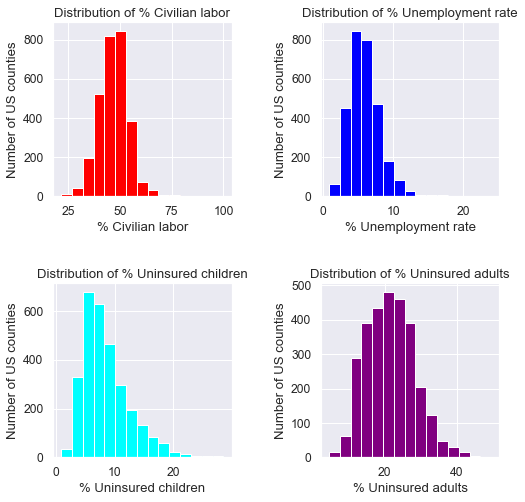

In [20]:
# Histogram analyses: economic indicators #               
plot_hist_2by2('econ__pct_civilian_labor', 15, '% Civilian labor',
              'econ__pct_unemployment', 15, '% Unemployment rate',
              'econ__pct_uninsured_children', 15, '% Uninsured children',
              'econ__pct_uninsured_adults', 15, '% Uninsured adults')    
plt.show()               

** Summary: Economic Indicators **
1. Labor: showed distribution is not quite normal. Majority of US counties have civilian labor more than 50%.
2. Unemployment rate: showed distribution skewed to right. Majority of US counties have unemployment rate at 5%.
3. Uninsured children: showed distribution skewed to right. Majority of US counties have uninsured children less than 10%.
4. Uninsured adults: showed distribution closer to normal. Majority of US counties have uninsured adults more than 20%.

** Histogram Analyses: Health Indicators [Group 1] **

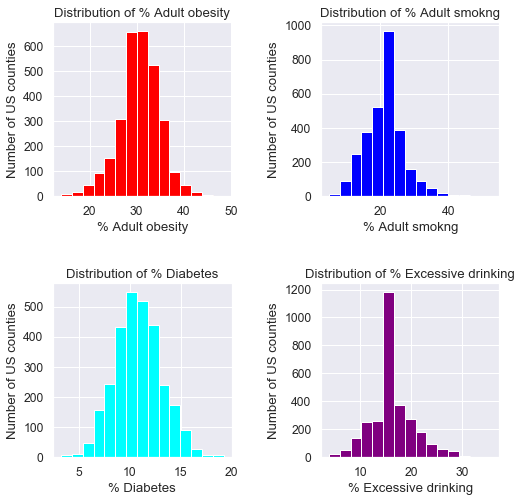

In [21]:
# Histogram analyses: health indicators #               
plot_hist_2by2('health__pct_adult_obesity', 15, '% Adult obesity',
              'health__pct_adult_smoking', 15, '% Adult smokng',
              'health__pct_diabetes', 15, '% Diabetes',
              'health__pct_excessive_drinking', 15, '% Excessive drinking')    
plt.show()               

** Summary: Health Indicators Group 1 **
1. Obesity: showed distribution closes to normal. Majority of US counties have adult obesity greater than 30%.
2. Adult smoking: showed distribution skewed to right. More than half of US counties smoking less than 25%.
3. Diabetes: showed distribution closes to normal. Majority of US counties have diabetes less than 10%.
4. Excessive drinking: showed distribution skewed to right. Majority of US counties have excessive drinking less than 15%.

** Histogram Analyses: Health Indicators [Group 2] **

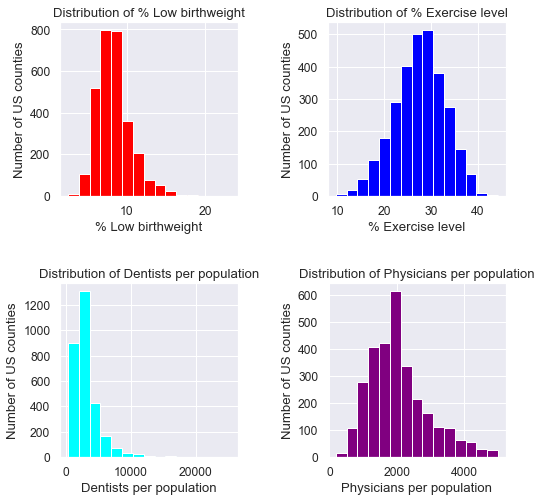

In [22]:
# Histogram analyses: health indicators II #               
plot_hist_2by2('health__pct_low_birthweight', 15, '% Low birthweight',
              'health__pct_physical_inacticity', 15, '% Exercise level',
              'health__pop_per_dentist', 15, 'Dentists per population',
              'health__pop_per_primary_care_physician', 15, 'Physicians per population')    
plt.show()               

** Summary: Health Indicators Group 2 **
1. Low birthweight: showed distribution skewed to right. Majority of US counties have low birthweight less than 10%.
2. Exercise level: showed distribution closes to normal. More than half of US counties exercise level greater than 30%.
3. Dentists per population: showed distribution skewed to right. Majority of US counties have dentists less than 5000 per population.
4. Doctors per population: showed distribution skewed to right. Majority of US counties have family doctors less than 2000 per population.

** Histogram Analyses: Demographic Indicators [Gender/Age] **

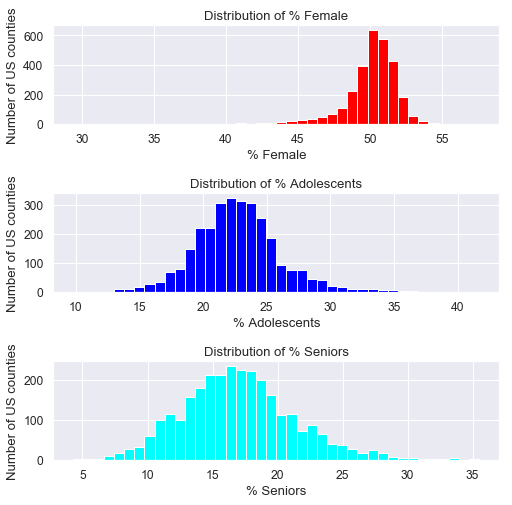

In [23]:
# Write a function: plot histogram
def plt_hist(x1,c1,b1,lab1):
    plt.hist(df_EDA[x1], color=c1, bins=b1)
    plt.title('Distribution of ' + lab1)
    plt.xlabel(lab1)
    plt.ylabel('Number of US counties')   

# Histogram analyses: gender/age demographic indicators #    
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
plt.subplot(3, 1, 1)
plt_hist('demo__pct_female', 'red', 40, '% Female')

plt.subplot(3, 1, 2)
plt_hist('demo__pct_below_18_years_of_age', 'blue', 40, '% Adolescents')

plt.subplot(3, 1, 3)
plt_hist('demo__pct_aged_65_years_and_older', 'cyan', 40, '% Seniors')
plt.show()

** Summary: Age/Gender Demographic Indicators **
1. % Female: showed distribution slightly skewed to left. Majority of US counties had greater than 50% of female.
2. % Adolescents: showed normal distribution. Majority of US counties had greater than 23% of adolescent population.
3. % Seniors: showed normal distribution. Majority of US counties had greater than 17% of adolescent population.

** Histogram Analyses: Demographic Indicators [Education] **

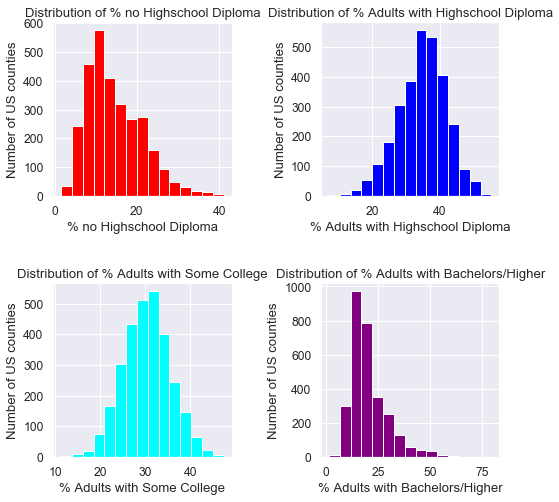

In [24]:
# Histogram analyses: education indicators #               
plot_hist_2by2('demo__pct_adults_less_than_a_high_school_diploma', 15, '% no Highschool Diploma',
              'demo__pct_adults_with_high_school_diploma', 15, '% Adults with Highschool Diploma',
              'demo__pct_adults_with_some_college', 15, '% Adults with Some College',
              'demo__pct_adults_bachelors_or_higher', 15, '% Adults with Bachelors/Higher')    
plt.show()               

** Summary: Demographic Indicators [Education] **
1. No high school diploma: showed distribution skewed to right. Majority of US counties have adults with no high school diploma less than 15%.
2. With high school diploma: showed distribution closes to normal. More than half of US counties have high school diploma greater than 30%.
3. With some college: showed distribution closes to normal. Majority of US counties have adults with some college education greater than 30%.
4. With university degree: showed distribution skewed to right. Majority of US counties have university degree less than 20%.

** Histogram Analyses: Demographic Indicators [Ethnicity] **

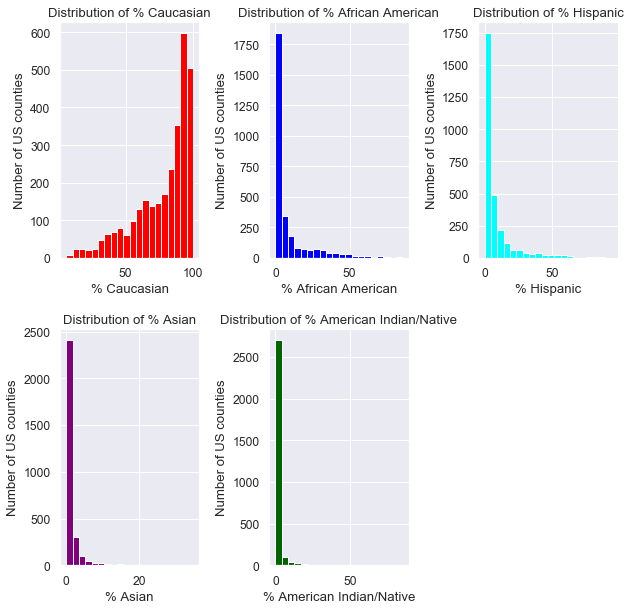

In [25]:
# Histogram analyses: ethnicity demographic indicators #    
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.subplot(2, 3, 1)
plt_hist('demo__pct_non_hispanic_white', 'red', 20, '% Caucasian')

plt.subplot(2, 3, 2)
plt_hist('demo__pct_non_hispanic_african_american', 'blue', 20, '% African American')

plt.subplot(2, 3, 3)
plt_hist('demo__pct_hispanic', 'cyan', 20, '% Hispanic')

plt.subplot(2, 3, 4)
plt_hist('demo__pct_asian', 'purple', 20, '% Asian')

plt.subplot(2, 3, 5)
plt_hist('demo__pct_american_indian_or_alaskan_native', 'darkgreen', 20, '% American Indian/Native')
plt.show()

** Summary: Demographic Indicators [Ethnicity] **
1. Caucasian: showed distribution skewed to left. In majority of US counties, more than 70% of Caucasian.
2. African American: showed distribution skewed to right. In majority of US counties, less than 5% of African American.
3. Hispanic: showed distribution skewed to right. In majority of US counties, less than 5% of Hispanic.
4. Asian: showed distribution skewed to right. In majority of US counties, less than 5% of Asian
5. American Indian: showed distribution skewed to right. In majority of US counties, less than 5% of American Indian.

** Histogram Analyses: Demographic Indicators [Death/Birth] **

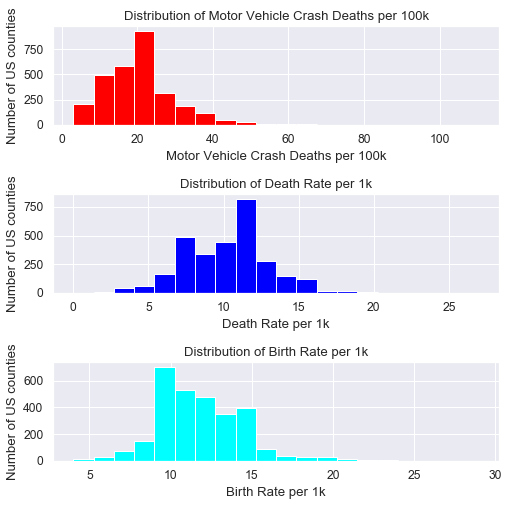

In [26]:
# Histogram analyses: death/birth rate demographic indicators #    
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
plt.subplot(3, 1, 1)
plt_hist('health__motor_vehicle_crash_deaths_per_100k', 'red', 20, 'Motor Vehicle Crash Deaths per 100k')

plt.subplot(3, 1, 2)
plt_hist('demo__death_rate_per_1k', 'blue', 20, 'Death Rate per 1k')

plt.subplot(3, 1, 3)
plt_hist('demo__birth_rate_per_1k', 'cyan', 20, 'Birth Rate per 1k')
plt.show()

** Summary: Demographic Indicators [Birth/Death Rate] **
1. Car accident deaths: showed distribution skewed to right. In majority of US counties, less than 20 vehicle crashes per 100k population.
2. Death rate: showed distribution skewed to right. In majority of US counties, less than 12.5 death rate per 1k population.
3. Birth rate: showed distribution skewed to right. In majority of US counties, less than 12.5 birth rate per 1k population.

** B2. Univariate Analysis: categorical features **

Let's create some bar charts/box plots using economoic typology and urban_rural influenial factors.

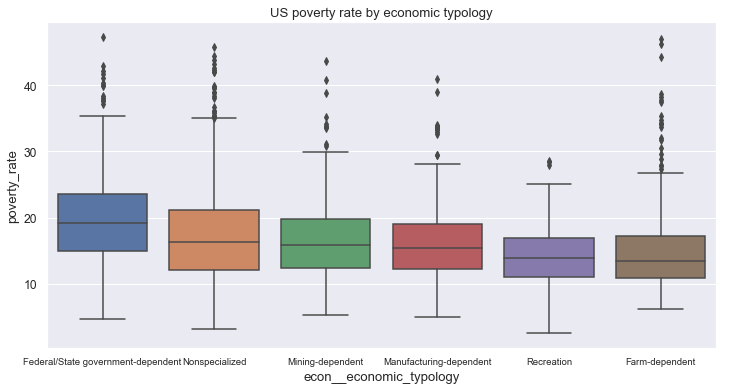

In [27]:
# Visualization: categorical and scale #
########################################
# economic typology:
plt.figure(figsize = (12, 6))
plt.title('US poverty rate by economic typology')
sns.boxplot(x = 'econ__economic_typology', y = 'poverty_rate',  data = df_EDA,
           order = ['Federal/State government-dependent','Nonspecialized','Mining-dependent',
                   'Manufacturing-dependent','Recreation','Farm-dependent'])
xt = plt.xticks(rotation=0, fontsize=9.5)
plt.show()

# Write a function to groupby and plot:
def grp_by_plot(x,y):
    df_grp = df_EDA.groupby(x)[y].mean().sort_values(ascending=False)
    df_grp.plot(kind='bar').set_xlabel(x)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel('mean poverty rate %')
    return None

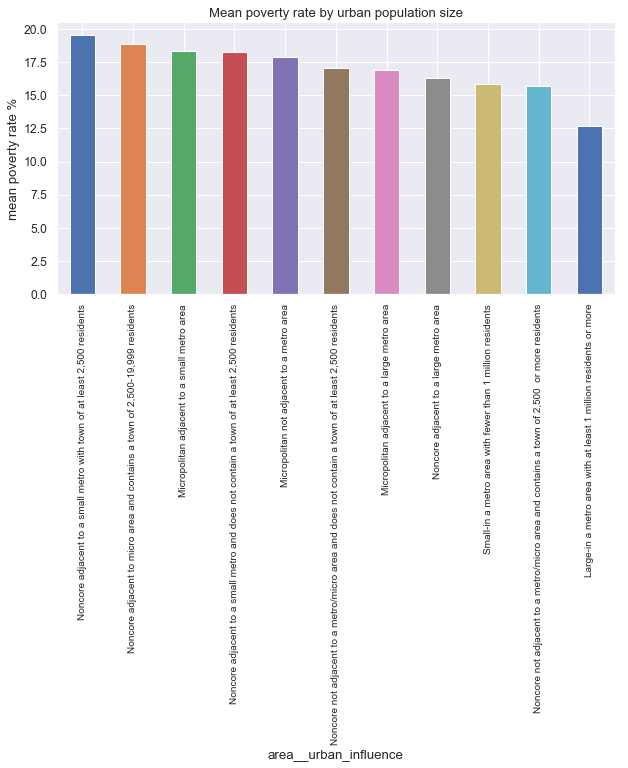

In [28]:
# Urban influence: population size
plt.figure(figsize = (10, 5))
grp_by_plot('area__urban_influence','poverty_rate')
plt.title('Mean poverty rate by urban population size')
plt.show()

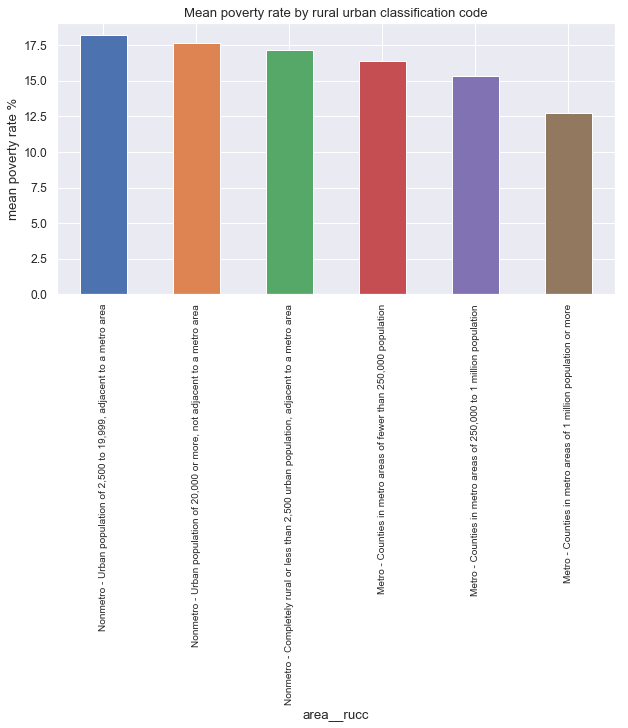

In [29]:
# Rural Urban Continuum Code:
plt.figure(figsize = (10, 5))
grp_by_plot('area__rucc','poverty_rate')
plt.title('Mean poverty rate by rural urban classification code')
plt.show()

** Summary: **
Based on a boxplot and bar charts plotted by different categorical factors, following trends were observed:
1. Economic typology: federal state dependent counties showed the highest poverty rate (19.5%). On contrary, farming dependent counties had the lowest poverty rate (14%).
2. Urbanization degree: with increased in population size from small micropolitan to large metropolitan counties, poverty rates were decreased.
3. Urban rural classification: from non-metro to metro counties, the poverty rates were going down (17.5% vs. 12.5%).

** B3. Bivariate Analyses: cross tabulation **

To explore relationships between two categorical features

In [30]:
# Test Cross Tablulation:
ct = pd.crosstab(df_EDA.area__rucc, df_EDA.econ__economic_typology)
ct

econ__economic_typology,Farm-dependent,Federal/State government-dependent,Manufacturing-dependent,Mining-dependent,Nonspecialized,Recreation
area__rucc,,,,,,
Metro - Counties in metro areas of 1 million population or more,3,36,36,12,277,41
"Metro - Counties in metro areas of 250,000 to 1 million population",8,45,47,12,190,32
"Metro - Counties in metro areas of fewer than 250,000 population",25,60,38,19,127,20
"Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area",300,62,59,65,92,68
"Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area",100,102,192,108,360,93
"Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area",2,48,67,16,146,42


** Summary: ** Based on a cross tab between economic typology and rural-urban classification, following trends were observed:
1. With respect to non-specialized: the largest number of counties were non-specialized and non-metro with population size of 2,500 to 19,999. Followed by non-specialized and metro counties with population over 1 million.
2. With respect to farm-dependent: most of counties were dependent on farming industries in non-metro with less than 2,500 population (rural area).
3. In mid-size non-metro with population of 2,500 to 19,999, most of counties were dependent on manufacturing and mining.
4. In small size non-metro with population of 2,500 to 19,999 were mostly dependent on federal/state government funding.

** B4. Bivariate Analyses: scatter plots **

To explore relationships between numerical features

In [31]:
## Write a plot function: scatter sub-plots ##
def scatter_plot(x1,x2,y,
                 var1,var2,c1,c2):
    plt.figure(figsize=(8,8))
    plt.subplots_adjust(hspace=0.4, wspace=0.9)
    plt.subplot(2,1,1)
    plt.scatter(x1, y, color=c1)
    plt.title('Relationship between'+var1+ 'and Poverty Rate')
    plt.xlabel(var1)
    plt.ylabel('Poverty Rate')

    plt.subplot(2,1,2)
    plt.scatter(x2, y, color=c2)
    plt.title('Relationship between'+var2+ 'and Poverty Rate')
    plt.xlabel(var2)
    plt.ylabel('Poverty Rate')
    return None

### B4A. Economic Indicators on poverty rate: ###

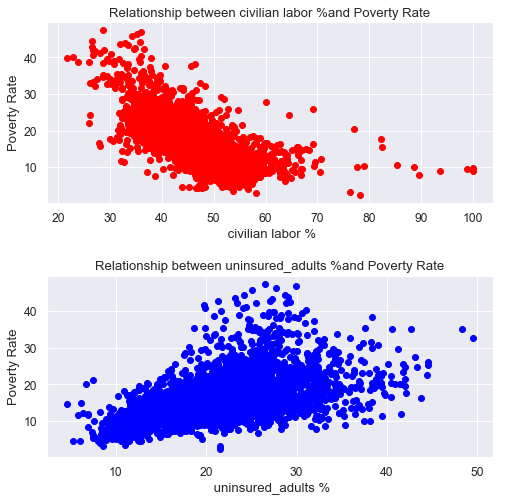

In [32]:
# Plot 1: econ__pct_uninsured_adults, vs. poverty_rate
# Plot 2: pct_uninsured_adults vs. poverty_rate
scatter_plot(df_EDA.econ__pct_civilian_labor, 
             df_EDA.econ__pct_uninsured_adults, df_EDA.poverty_rate, 
             ' civilian labor %', ' uninsured_adults %', c1='red', c2='blue')
plt.show()

** Summary: Relationshp between economic indicators vs. poverty rate. **
1. % civilian labor: a strong trend of increased in labor power, decreased in poverty rate was observed.
2. % uninsured adults: a trend of increased in uninsured adults, decreased in poverty rate was observed.

### B4B. Health Indicators on poverty rate: ###

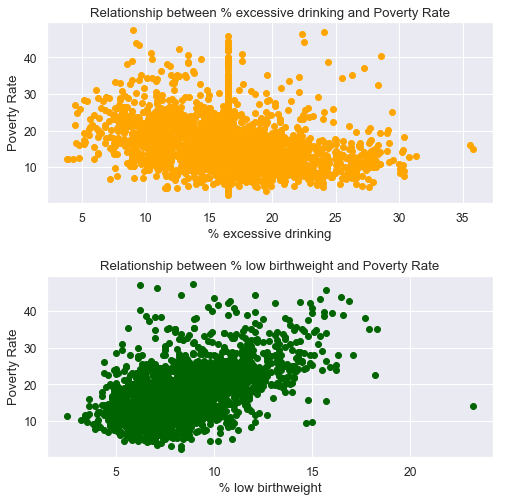

In [33]:
# Plot 3: health__pct_excessive_drinking vs. poverty_rate
# Plot 4: health__pct_low_birthweight vs. poverty_rate
scatter_plot(df_EDA.health__pct_excessive_drinking, 
             df_EDA.health__pct_low_birthweight, df_EDA.poverty_rate, 
             ' % excessive drinking ', ' % low birthweight ', c1='orange', c2='darkgreen')
plt.show()

** Summary: Relationshp between health indicators vs. poverty rate. **
1. % excessive drinking: higher the excessive drinking %, slight decreased in poverty rates were observed.
2. % low birthweight: higher the low birthweight %, increased in poverty rates were observed.

### B4C. Education Demographic Indicators on poverty rate: ###

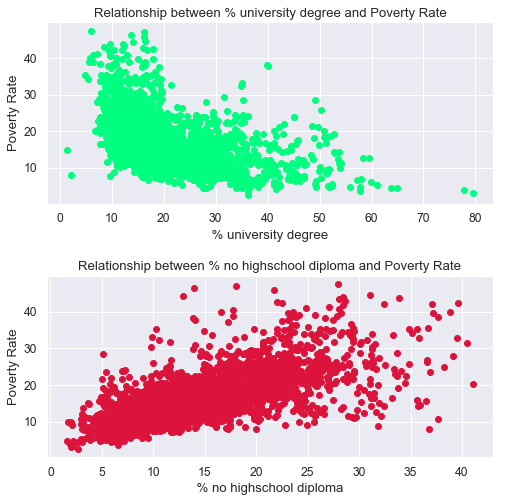

In [34]:
# Plot 5: demo__pct_adults_less_than_a_high_school_diploma vs. poverty_rate
# Plot 6: demo__pct_adults_bachelors_or_higher, vs. poverty_rate
scatter_plot(df_EDA.demo__pct_adults_bachelors_or_higher, 
             df_EDA.demo__pct_adults_less_than_a_high_school_diploma, df_EDA.poverty_rate, 
             ' % university degree ', ' % no highschool diploma ', c1='springgreen', c2='crimson')
plt.show()

** Summary: Relationshp between education level indicators vs. poverty rate. **
1. % university education: increased in university degree %, lower poverty rates were observed.
2. % no highschool diploma: increased in % of no highschool diploma, higher poverty rates were observed.

### B4D. Age Demographic Indicators on poverty rate: ###

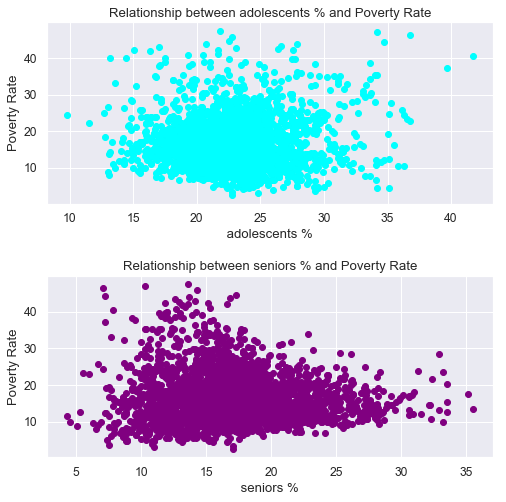

In [35]:
# Plot 7: demo__pct_below_18_years_of_age vs. poverty_rate
# Plot 8: demo__pct_aged_65_years_and_older, vs. poverty_rate
scatter_plot(df_EDA.demo__pct_below_18_years_of_age, 
             df_EDA.demo__pct_aged_65_years_and_older, df_EDA.poverty_rate, 
             ' adolescents % ', ' seniors % ', c1='cyan', c2='purple')
plt.show()

** Summary: Relationshp between age demographic indicators vs. poverty rate. **
1. % adolescents: no clear trends were observed with increased in % adolescents and poverty rate.
2. % seniors: no clear trends were observed with increased in % seniors and poverty rate.

** B5. Multi-Faceted Relationships: scatter plots **

To explore relationships between numerical features conditioned by a categorical feature.

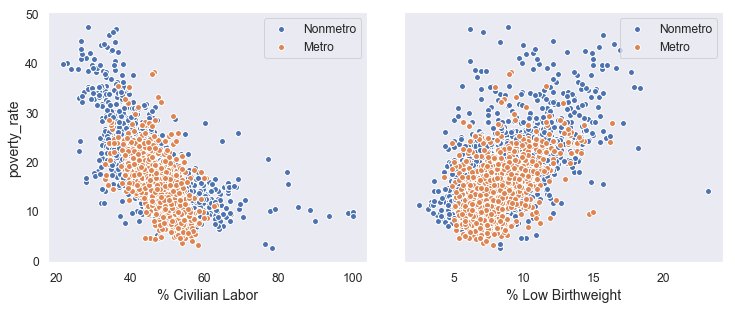

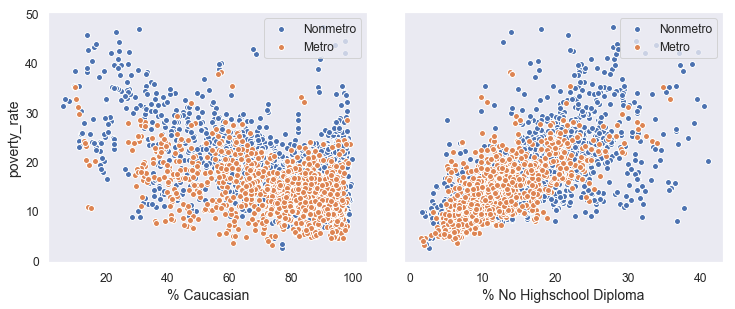

In [36]:
# Prepare dataframes filtered by Nonmetro and Metro counties:
df_non_metro = df_EDA[df_EDA['county_class'] == 'Nonmetro']
df_metro = df_EDA[df_EDA['county_class'] == 'Metro']

# Write a function for multi-dimensional scatter plots #
def multi_sct_plots(x1,xlab1,x2,xlab2,y):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout(pad=0.4, w_pad=1.5, h_pad=1.0)
    ax1.scatter(df_non_metro[x1], df_non_metro[y], label='Nonmetro', edgecolor='w')
    ax1.scatter(df_metro[x1], df_metro[y], label='Metro', edgecolor='w')
    ax1.legend(loc='upper right')
    ax1.set_xlabel(xlab1, fontsize=14)
    ax1.set_ylabel(y, fontsize=14)
    ax1.grid(False)
#    ax1.set_axis_bgcolor('white')
    ax2.scatter(df_non_metro[x2], df_non_metro[y], label='Nonmetro', edgecolor='w')
    ax2.scatter(df_metro[x2], df_metro[y], label='Metro', edgecolor='w')
    ax2.legend(loc='upper right')
    ax2.set_xlabel(xlab2, fontsize=14)
    ax2.grid(False)
#    ax2.set_axis_bgcolor('white')
    plt.show()

# Multi-faceted plot: % civilian labor and % low birthweight vs. poverty rate    
multi_sct_plots('econ__pct_civilian_labor', '% Civilian Labor',
              'health__pct_low_birthweight', '% Low Birthweight', 'poverty_rate')

# Multi-faceted plot: % Caucasian and % no highschool diploma vs. poverty rate    
multi_sct_plots('demo__pct_non_hispanic_white', '% Caucasian',
              'demo__pct_adults_less_than_a_high_school_diploma', '% No Highschool Diploma', 'poverty_rate')

** Summary: Relationships between scoio-economic factors and poverty rate conditioned by urbanization degree **

Firstly, US poverty rates were tend to be lower in metro vs nonmetro area counties. Secondly, the distribution or sparsity of scatter plots is higher in nonmetro than metro area counties. In general, observed poverty rate variance was lower in metro area counties compared to non-metro area counties.

** B6. Multi-Faceted Relationships: scatter plots **

To explore relationships between numerical features colored by target variable.

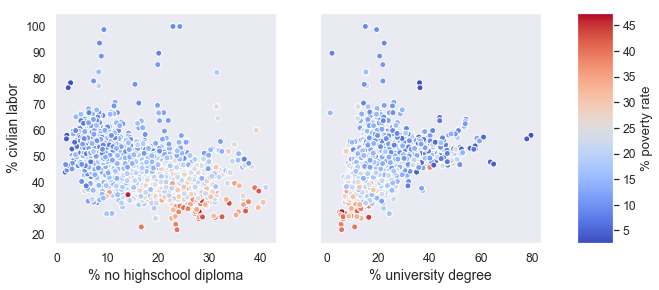

In [37]:
# Write a function: scatter plot colored by poverty_rate #
def plot_color_sct_x(x1, xlab1, x2, xlab2,
                   y, ylab, z, zlab):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))
    # Scatter plot: subplot 1
    s1 = ax1.scatter(df_EDA[x1], df_EDA[y], c=df_EDA[z],
               cmap = plt.cm.coolwarm, edgecolor='w')
    ax1.set_xlabel(xlab1, fontsize=14)
    ax1.set_ylabel(ylab, fontsize=14)
    ax1.grid(False)
#    cb1 = plt.colorbar(s1, ax=ax1, orientation='horizontal', pad=0.12)
#    cb1.set_label(zlab)
    # Scatter plot: subplot 2
    s2 = ax2.scatter(df_EDA[x2], df_EDA[y], c=df_EDA[z],
               cmap = plt.cm.coolwarm, edgecolor='w')
    ax2.set_xlabel(xlab2, fontsize=14)
    ax2.grid(False)
    # Plot color bar:
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    cax = plt.axes([0.85, 0.1, 0.05, 0.8])
    cb = f.colorbar(s1, cax=cax)
    cb.set_label(zlab)

# Plot a color scaled scatter plot by poverty rate:
plot_color_sct_x('demo__pct_adults_less_than_a_high_school_diploma', '% no highschool diploma',
               'demo__pct_adults_bachelors_or_higher', '% university degree',
               'econ__pct_civilian_labor', '% civlian labor',
               'poverty_rate', '% poverty rate')
plt.show()

** Summary: Relationships between scoio-economic factors color scaled by level of poverty rate **

1. % no high school diploma vs. % university degree: these top two plots showed that higher the education level of population, increased in % of civilian labor. Thus, poverty rates were found to be lower.

## Part C. Machine Learning: Regression Analysis ##
Here, 
Y  = poverty rate (called "target" data and referred to as the dependent variable or response variable) and
X  = all the other features (or independent variables, predictors or explanatory variables).

In which, we will use to fit a set of different regression models and predict poverty rate across US counties. 
We will compare different types of regression models available on scikit-learn and statsmodel OLS libraries:
* Linear Regression
* Multiple Linear Regression
* Polynomial Regression
* DecisionTree Regression
* RandomForest Regression
* XGBoost Regression

### Dummy Variable Encoding: nominal features  ###
Dummy variable encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator get interpreted well to the ML models for making accurate prediction. Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: econ_farm_depmendent vs. econ_mining vs. etc.).

In [38]:
# Perform dummy variable encoding on nominal features #
###############################################################################
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
df2 = pd.get_dummies(df_cleaned.drop(['row_id'],axis=1),
                                  drop_first=True)

# List total number of encoded inputs and output:
df2.isnull().sum()

# Reset index: from 0 to 2949
df2 = df2.reset_index(drop=True)

### Split on input features and target variable  ###
For US poverty rate regression problem, following set of regressors were tested which included linear regression, multi-linear, polynomial, decision tree, random forest and gradient boosting (XGBoost).

After each model construction, RandomizedSearchCV module was applied to tune hyper parameters (i.e., C, n_estimators, etc.) on each model. These optimized models will provide us to achieve the best desired performance for making predictions on poverty rates with the least RMSE and max R^2 values.

### Data Partition ###
Next step is data partition. It is an absolute requirement procedure in which split original data into training and test sets. Thus, it aims to separate data for model training and model perfomance evaluation.

In [39]:
# Split input features and output (target) variable:
X, y = df2.drop(['poverty_rate'], axis=1), df2['poverty_rate']

# Data Partition & Feature Scaling #
####################################
# Split training set and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=1/4, random_state=123)

### Feature Selection: using L1 regularization (LASSO) ###

In [40]:
# Feature Selection: L1 Regularization (LASSO) #
###############################################################################
# Fit L1 regularization to figure out non-zero coefficients:
lr_L1 = Lasso(alpha=0.01)
lr_L1.fit(X_train,y_train)

# Print estimated intercept coefficient:
print('Est. coefficient: {}'.format(lr_L1.intercept_))

# Feature selection dataframe: using L1 fitted coefficients
df_L1 = pd.DataFrame({'features':X.columns, 'EstCoef':lr_L1.coef_})[['features','EstCoef']]
df_L1_selected = df_L1.sort_values(by='EstCoef',ascending=False)

# Select top 10 features: from L1 Regualarization
df_L1_selected[abs(df_L1_selected['EstCoef']) > 2.0]

Est. coefficient: 21.910967313102418


,features,EstCoef
12,demo__pct_adults_less_than_a_high_school_diploma,30.664829
10,demo__pct_american_indian_or_alaskan_native,11.107816
8,demo__pct_non_hispanic_african_american,10.899662
2,econ__pct_uninsured_adults,9.347931
1,econ__pct_unemployment,8.211622
19,health__pct_adult_smoking,4.891268
14,demo__pct_adults_with_some_college,-2.168645
32,area__rucc_6,-2.774770
5,demo__pct_below_18_years_of_age,-6.633681
3,econ__pct_uninsured_children,-13.203098


### Feature Selection: using L2 regularization (Ridge) ###

In [41]:
# Feature Selection: L2 Regularization (Ridge) #
###############################################################################
# Fit L2 regularization to figure out non-zero coefficients:
lr_L2 = Ridge(alpha=0.01)
lr_L2.fit(X_train,y_train)

# Print estimated intercept coefficient:
print('Est. coefficient: {}'.format(lr_L2.intercept_))

# Feature selection dataframe: using L1 fitted coefficients
df_L2 = pd.DataFrame({'features':X.columns, 'EstCoef':lr_L2.coef_})[['features','EstCoef']]
df_L2_selected = df_L2.sort_values(by='EstCoef',ascending=False)

# Select top 10 features: from L2 Regualarization
df_L2_selected[abs(df_L2_selected['EstCoef']) > 14.0].sort_index()

Est. coefficient: 27.189564906566318


,features,EstCoef
0,econ__pct_civilian_labor,-19.844446
1,econ__pct_unemployment,30.391101
2,econ__pct_uninsured_adults,21.825856
3,econ__pct_uninsured_children,-30.289618
4,demo__pct_female,18.088753
5,demo__pct_below_18_years_of_age,-46.351150
6,demo__pct_aged_65_years_and_older,-33.335659
10,demo__pct_american_indian_or_alaskan_native,19.556212
12,demo__pct_adults_less_than_a_high_school_diploma,20.510557
21,health__pct_low_birthweight,23.560460


### Feature Selection: using Feature Importance module ###
FIP module is available on DecisionTree, RandomForest and XGBoost regressors.

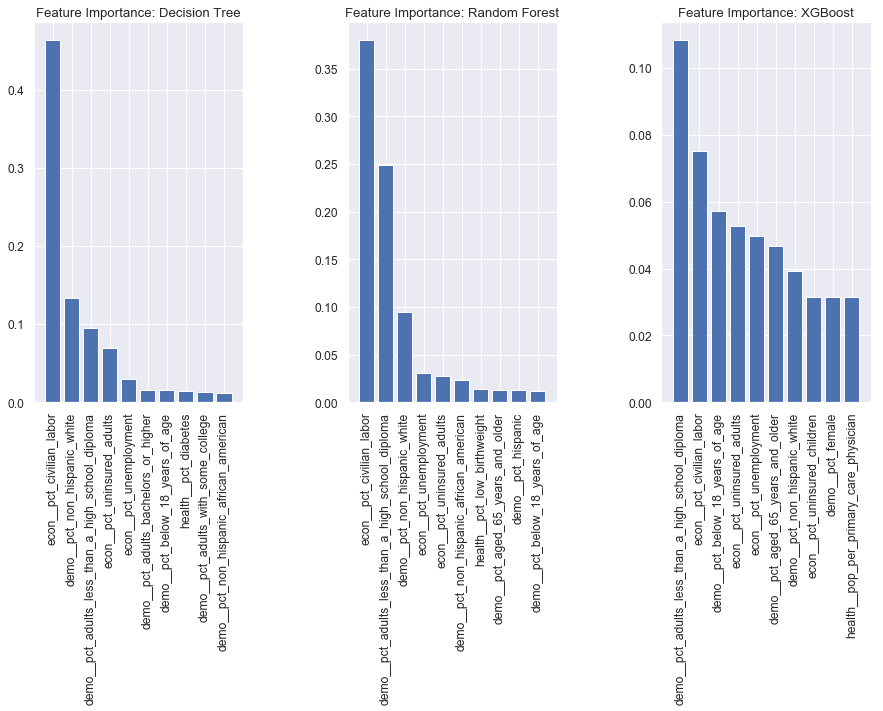

In [42]:
# Feature Selection: Feature Importance #
#########################################
# Write a function F.I.P plot #
def fip_plot(model):
    model = model
    model.fit(X_train, y_train)
    feat_labels = X_train.columns[0:]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][0:10]

    #for f in range(10):
        #print("%2d) %-*s %f" % (f + 1, 30, 
                            #feat_labels[indices[f]],
                            #importances[indices[f]]))

    plt.bar(range(10), importances[indices], align='center')
    plt.xticks(range(10), feat_labels[indices], rotation=90)
    plt.xlim(-1, 10)

plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.5)
    
# Using a Decision Tree: Top 12 features:
plt.subplot(1,3,1)
fip_plot(DecisionTreeRegressor(random_state=0))
plt.title('Feature Importance: Decision Tree')

# Using a RandomForest: Top 12 features:
plt.subplot(1,3,2)
fip_plot(RandomForestRegressor(random_state=0))
plt.title('Feature Importance: Random Forest')

# Using a XGBoost: Top 12 features:
plt.subplot(1,3,3)
fip_plot(XGBRegressor(random_state=0))
plt.title('Feature Importance: XGBoost')
plt.show()

### Feature Scaling ###
Feature scaling is a step in which a scaler function (i.e., min-max, logarithmic, etc.) standardize different range of features into a close proximity (i.e., ranges). This helps some regression model(s) to handle importance of features in a normalized equal weighted fashion. Feature scaling was applied before training different kinds of regression algorithms.

In [43]:
# Apply Feature Scaling: using StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
y_train_std = sc_y.fit_transform(y_train[:,np.newaxis]).flatten()
y_test_std = sc_y.fit_transform(y_test[:,np.newaxis]).flatten()

### Visualization: filter outliers using RANSAC model ###

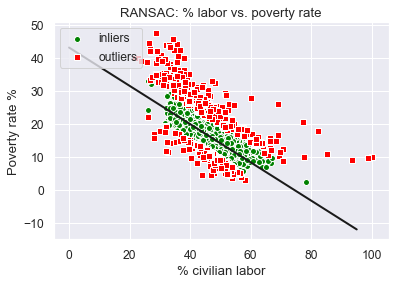

Slope: -0.579
Intercept: 43.077


In [44]:
#########################################
# Viz Test: outliers using RANSAC model #
#########################################
# Feature: econ__pct_civilian_labor without scaling
X_train_labor= X_train[['econ__pct_civilian_labor']].values*100

from sklearn.linear_model import RANSACRegressor
lr_ransac = RANSACRegressor(LinearRegression(), max_trials=100,
                            min_samples=50, loss='absolute_loss',
                            residual_threshold=5.0, random_state=123)
lr_ransac.fit(X_train_labor, y_train)
inlier_mask = lr_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(0,100,5.0)
line_y = lr_ransac.predict(line_X[:, np.newaxis])

plt.scatter(X_train_labor[inlier_mask], y_train[inlier_mask],
            c='green', edgecolor='w',
            marker='o', label='inliers')
plt.scatter(X_train_labor[outlier_mask], y_train[outlier_mask],
            c='red', edgecolor='w',
            marker='s', label='outliers')
plt.plot(line_X, line_y, c='k', lw=2)
plt.title('RANSAC: % labor vs. poverty rate')
plt.xlabel('% civilian labor')
plt.ylabel('Poverty rate %')
plt.legend(loc='upper left')
plt.show()
print('Slope: %.3f' % lr_ransac.estimator_.coef_[0])
print('Intercept: %.3f' % lr_ransac.estimator_.intercept_)

#### Summary: RANSAC model ####
Using RANSAC fitted model, we can visually inspect inliers and outliers. Outliers were present uniformly across low to high % of civilian labor counties in US.

### Visualization: line of best fit - regression model ###

To have better understanding on how line of best fit would look for different regression models, we decided to choose **'% of civilian labor'** as an input feature. It was reported as the most important feature based on outcomes of various feature selection tests (i.e., L1/L2 regularization and feature importance module on tree models, etc.)

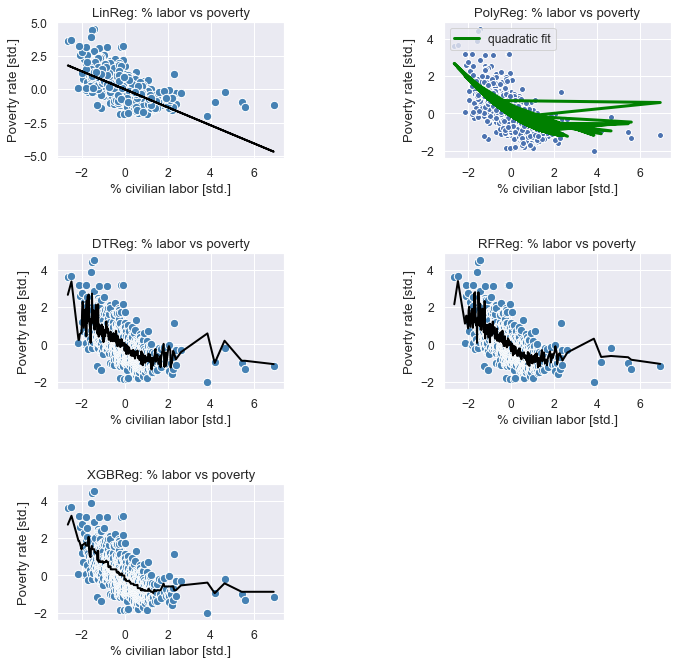

In [45]:
# Create a function: scatter plot + model fitted REG line
def reg_fit_plot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='w', s=70) # (x, y, c, edgecolor, s)
    plt.plot(X, model.predict(X), color='black', lw=2) #(x, predict, color, lw)
    return None

# Define input features: 1 predictor (pct_less_than_high_school_diploma)
X_train_labor_std = sc_x.fit_transform(X_train[['econ__pct_civilian_labor']]) 
X_test_labor_std = sc_x.fit_transform(X_test[['econ__pct_civilian_labor']])

##############################
# Model Fitting: Regressions #
##############################

# Fit Linear Regressor()
####################################################################
# Fit a simple Linear Regression:
lr = LinearRegression()
lr.fit(X_train_labor_std, y_train_std)

# Fit Polynomial Regressor()
####################################################################
# Fit a simple Linear Regression:
lr = LinearRegression()
lr.fit(X_train_labor_std, y_train_std)

# Fit a quad Polynomial Linear Regression:
pr = PolynomialFeatures(degree=2)
X_train_poly_std = pr.fit_transform(X_train_labor_std)
X_test_poly_std = pr.fit_transform(X_test_labor_std)
lr_2 = LinearRegression()
lr_2.fit(X_train_poly_std, y_train_std)

# Sort index for test set: for non-linear regressor models #
sort_idx = X_test_labor_std.flatten().argsort()

# Fit DecisionTree Regressor():
####################################################################
tree = DecisionTreeRegressor()
tree.fit(X_train_labor_std, y_train_std)

# Fit RandomForest Regressor():
####################################################################
forest = RandomForestRegressor()
forest.fit(X_train_labor_std, y_train_std)

# Fit XGBoost Regressor():
####################################################################
xgb = XGBRegressor()
xgb.fit(X_train_labor_std, y_train_std)
####################################################################

###################################
# Visualization: Line of best fit #
###################################
# Subplot 1: Linear Regression - % labor vs. poverty rate
####################################################################
plt.figure(figsize=(11,11))
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.subplot(3,2,1)
reg_fit_plot(X_test_labor_std, y_test_std, lr)
plt.title('LinReg: % labor vs poverty')
plt.xlabel('% civilian labor [std.]')
plt.ylabel('Poverty rate [std.]')
            
# Subplot 2: Polynomial Regression - % labor vs. poverty rate
####################################################################
plt.subplot(3,2,2)
plt.scatter(X_test_labor_std, y_test_std, edgecolor='w')#, label='test set')
#plt.plot(X_test_labor_std, lr.predict(X_test_labor_std),
#        label='linear fit', color='black', lw=3)
plt.plot(X_test_labor_std, lr_2.predict(X_test_poly_std),
        label='quadratic fit', color='green', lw=3)
plt.title('PolyReg: % labor vs poverty')
plt.xlabel('% civilian labor [std.]')
plt.ylabel('Poverty rate [std.]')
plt.legend(loc='upper left')

# Subplot 3: DecisionTree Regression - % labor vs. poverty rate
####################################################################
plt.subplot(3,2,3)
reg_fit_plot(X_test_labor_std[sort_idx], y_test_std[sort_idx], tree)
plt.title('DTReg: % labor vs poverty')
plt.xlabel('% civilian labor [std.]')
plt.ylabel('Poverty rate [std.]')

# Subplot 4: RF Regression - % labor vs. poverty rate
####################################################################
plt.subplot(3,2,4)
reg_fit_plot(X_test_labor_std[sort_idx], y_test_std[sort_idx], forest)
plt.title('RFReg: % labor vs poverty')
plt.xlabel('% civilian labor [std.]')
plt.ylabel('Poverty rate [std.]')

# Subplot 5: XGB Regression - % labor vs. poverty rate
####################################################################
plt.subplot(3,2,5)
reg_fit_plot(X_test_labor_std[sort_idx], y_test_std[sort_idx], xgb)
plt.title('XGBReg: % labor vs poverty')
plt.xlabel('% civilian labor [std.]')
plt.ylabel('Poverty rate [std.]')
plt.show()

** Summary: visualization on regression models - line of best fit **

Visually, we can see that random forest and XGBoost fits are quite descent and well fitted.

### K-fold Cross Validation ###
Using L1 selected features, k-fold cross validation approached will be used for model training and optimize model hyperparameters. Firstly, earlier training set from data partition step was used to divde data into multiple folds. In each iteration, one fold was used as validation for optimizing model parameters and remaining folds were used for training model(s). Note that this procedure will be repeated "k" times as we specified where each validation fold shuffled between iterations. Finally, overal model performance would be average across all iterations to provide the best model hyperparameters.

In [46]:
###############################
# Selected Features by Top 10 #
###############################
# L1 regularized: 10 features
#[0,1,2,3,5,8,10,12,14,19]
# L2 regularized: 10 features
#[0,1,2,3,4,5,6,10,12,21]
# FIP from DTRegressor: 10 features
#[0,1,2,5,8,9,12,14,15,20] 
# FIP from RFRegressor: 10 features
#[0,1,2,5,6,7,8,9,12,21]
# FIP from XGBRegressor: 10 features
#[0,1,2,3,4,5,6,9,12,27]

#############################################################################################    
# [Linear Reg]: Define input features #
#######################################
X_train_std_lr = sc_x.fit_transform(X_train.iloc[:, [0,1,2,3,4,5,6,7,8,10,12,21]])
X_test_std_lr = sc_x.fit_transform(X_test.iloc[:, [0,1,2,3,4,5,6,7,8,10,12,21]])

# [Linear Reg]: K-fold cross validation #
#########################################
kf = KFold(n_splits=10, random_state=123)
for train_idx, validate_idx in kf.split(X_train_std_lr):
    X_train_kf_lr, X_validate_kf_lr = X_train_std_lr[train_idx], X_train_std_lr[validate_idx]
    y_train_kf, y_validate_kf = y_train_std[train_idx], y_train_std[validate_idx]
#############################################################################################       

#############################################################################################    
# [Poly Reg]: Define input features #
#######################################
X_train_std_pr = sc_x.fit_transform(X_train.iloc[:, [0,1,2,3,4,5,6,7,8,10,12,21]])
X_test_std_pr = sc_x.fit_transform(X_test.iloc[:, [0,1,2,3,4,5,6,7,8,10,12,21]])

# [Poly Reg]: K-fold cross validation #
#########################################
kf = KFold(n_splits=10, random_state=123)
for train_idx, validate_idx in kf.split(X_train_std_pr):
    X_train_kf_pr, X_validate_kf_pr = X_train_std_pr[train_idx], X_train_std_pr[validate_idx]
#############################################################################################       

#############################################################################################    
# [DT Reg]: Define input features #
#######################################
X_train_std_dt = sc_x.fit_transform(X_train.iloc[:, [0,1,2,5,8,9,12,14,15,20]])
X_test_std_dt = sc_x.fit_transform(X_test.iloc[:, [0,1,2,5,8,9,12,14,15,20]])

# [DT Reg]: K-fold cross validation #
#########################################
kf = KFold(n_splits=10, random_state=123)
for train_idx, validate_idx in kf.split(X_train_std_dt):
    X_train_kf_dt, X_validate_kf_dt = X_train_std_dt[train_idx], X_train_std_dt[validate_idx]
#############################################################################################    

#############################################################################################    
# [RF Reg]: Define input features #
#######################################
X_train_std_rf = sc_x.fit_transform(X_train.iloc[:, [0,1,2,5,6,7,8,9,12,21]])
X_test_std_rf = sc_x.fit_transform(X_test.iloc[:, [0,1,2,5,6,7,8,9,12,21]])

# [RF Reg]: K-fold cross validation #
#########################################
kf = KFold(n_splits=10, random_state=123)
for train_idx, validate_idx in kf.split(X_train_std_rf):
    X_train_kf_rf, X_validate_kf_rf = X_train_std_rf[train_idx], X_train_std_rf[validate_idx]
############################################################################################# 

#############################################################################################    
# [XGB Reg]: Define input features #
#######################################
X_train_std_xgb = sc_x.fit_transform(X_train.iloc[:, [0,1,2,3,4,5,6,9,12,27]])
X_test_std_xgb = sc_x.fit_transform(X_test.iloc[:, [0,1,2,3,4,5,6,9,12,27]])

# [XGB Reg]: K-fold cross validation #
#########################################
kf = KFold(n_splits=10, random_state=123)
for train_idx, validate_idx in kf.split(X_train_std_xgb):
    X_train_kf_xgb, X_validate_kf_xgb = X_train_std_xgb[train_idx], X_train_std_xgb[validate_idx]
#############################################################################################    

### Model Fitting: based on feature selection ###
Following choices of models were selected for predicting poverty rate in US counties:
* Linear Regression
* Multiple Linear Regression
* Polynomial Regression
* DecisionTree Regression
* RandomForest Regression
* XGBoost Regression

In [47]:
###############################
# Model 1. LinearRegression() #
###############################
############################################
# Apply LinearRegression: 
lr = LinearRegression()
lr.fit(X_train_kf_lr, y_train_kf)

# Make prediction: feature scaled inputs
y_train_pred_lr = lr.predict(X_train_kf_lr)
y_test_pred_lr = lr.predict(X_test_std_lr)
############################################

In [48]:
###############################
# Model 2. PolyLinRegression  #
###############################
# Re-fit PolyRegression: 
X_train_poly = pr.fit_transform(X_train_kf_pr)
X_test_poly = pr.fit_transform(X_test_std_pr)
lr_2 = LinearRegression()
lr_2.fit(X_train_poly, y_train_kf)

# Make prediction: PolyReg.
y_train_pred_pr = lr_2.predict(X_train_poly)
y_test_pred_pr = lr_2.predict(X_test_poly)

In [49]:
##########################
# Model 3. DTRegression  #
##########################
# Re-fit DTRegression: 
tree = DecisionTreeRegressor()
tree.fit(X_train_kf_dt, y_train_kf)
sort_idx = X_train_kf_dt.flatten().argsort()

# RandomizedSearchCV: DTRegressor
# Create hyperparameter list:
param_dist_dt = {'max_depth':sp.randint(2,10),
                 'max_leaf_nodes':sp.randint(2,10),
                 'min_samples_split':sp.randint(2,10),
                 'min_samples_leaf':sp.randint(2,10),
                 'criterion': ['mse','mae']}
random_search = RandomizedSearchCV(estimator=tree, param_distributions=param_dist_dt,
                                   random_state=123, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_validate_kf_dt, y_validate_kf)

# View best hyperparameters
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])

# Make prediction: DTReg.
y_train_pred_dt = random_search_dt.predict(X_train_kf_dt)
y_test_pred_dt = random_search_dt.predict(X_test_std_dt)

Best max_depth: 2
Best min_samples_split: 3
Best min_samples_leaf: 8


In [50]:
##########################
# Model 4. RFRegression  #
##########################
# Re-fit RFRegression: 
forest = RandomForestRegressor(n_estimators=100, criterion='mse',
                               random_state=123, n_jobs=-1)
forest.fit(X_train_kf_rf, y_train_kf)

# RandomizedSearchCV: RFRegressor
# Create hyperparameter list:
param_dist_rf = {'n_estimators':sp.randint(2,100), 
                  'max_depth':sp.randint(2,10),
                  'min_samples_split':sp.randint(2,10),
                  'min_samples_leaf':sp.randint(2,10),
                  'bootstrap': [True, False],
                  'criterion': ['mse','mae']}
random_search = RandomizedSearchCV(estimator=forest, param_distributions=param_dist_rf,
                                   random_state=123, n_iter=100)
random_search_rf = random_search.fit(X_validate_kf_rf, y_validate_kf)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

# Make prediction: RFReg.
y_train_pred_rf = random_search_rf.predict(X_train_kf_rf)
y_test_pred_rf = random_search_rf.predict(X_test_std_rf)

Best n_estimators: 85
Best max_depth: 6
Best min_samples_split: 8
Best min_samples_leaf: 3


In [51]:
##########################
# Model 5. XGBRegression #
##########################
# Re-fit XGBRegression: 
XGB = XGBRegressor()
XGB.fit(X_train_kf_xgb, y_train_kf)

# RandomizedSearchCV: XGBRegressor
# Create hyperparameter list:
param_dist_xgb = {'n_estimators':sp.randint(2,100), 
                  'max_depth':sp.randint(2,10),
                  'learning_rate':np.random.uniform(0,1,10),
                  'objective':['reg:linear']}
random_search = RandomizedSearchCV(estimator=XGB, param_distributions=param_dist_xgb,
                                   random_state=123, n_iter=100)
random_search_xgb = random_search.fit(X_validate_kf_xgb, y_validate_kf)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])

# Make prediction: XGBReg.
y_train_pred_xgb = random_search_xgb.predict(X_train_kf_xgb)
y_test_pred_xgb = random_search_xgb.predict(X_test_std_xgb)

Best n_estimators: 58
Best max_depth: 2
Best learning_rate: 0.530004658512
Best objective: reg:linear


### Model Evaluation: compute RMSE and R^2 ###
Note: before compute RMSE and R^2, we must transformed back to original scale on our original and predicted values.

In [52]:
# Write a function to inverse transform:
def sc_y_inv(y_train, y_test):
    y_train = sc_y.inverse_transform(y_train)
    y_test = sc_y.inverse_transform(y_test)
    return(y_train, y_test)

# Test: inverse transform [original scale] 
###############################################################################   
# Original poverty_rates:
y_train_act, y_test_act = sc_y_inv(y_train_kf, y_test_std)

# Predicted poverty_rates:
y_train_lr_pred, y_test_lr_pred = sc_y_inv(y_train_pred_lr, y_test_pred_lr)
y_train_pr_pred, y_test_pr_pred = sc_y_inv(y_train_pred_pr, y_test_pred_pr)
y_train_dt_pred, y_test_dt_pred = sc_y_inv(y_train_pred_dt, y_test_pred_dt)
y_train_rf_pred, y_test_rf_pred = sc_y_inv(y_train_pred_rf, y_test_pred_rf)
y_train_xgb_pred, y_test_xgb_pred = sc_y_inv(y_train_pred_xgb, y_test_pred_xgb)

# Write a function to compute RMSE:
def RMSE(y_train, y_train_pred,
         y_test, y_test_pred, text):
    print(text %(
        np.sqrt(skm.mean_squared_error(y_train, y_train_pred)),
        np.sqrt(skm.mean_squared_error(y_test, y_test_pred))))

# Write a function to compute R^2:
def R_2(y_train, y_train_pred,
         y_test, y_test_pred, text):
    print(text %(
        skm.r2_score(y_train, y_train_pred),
        skm.r2_score(y_test, y_test_pred)))
    
# Compute RMSE & R^2: training & test set #
# Linear Regression():
RMSE(y_train_act, y_train_lr_pred,
    y_test_act, y_test_lr_pred,
    'LinReg: RMSE train:%.3f, test:%.3f')

R_2(y_train_act, y_train_lr_pred,
    y_test_act, y_test_lr_pred,
    'LinReg: R^2 train:%.3f, test:%.3f')

# Poly Regression():
RMSE(y_train_act, y_train_pr_pred,
    y_test_act, y_test_pr_pred,
    'PolyReg: RMSE train:%.3f, test:%.3f')

R_2(y_train_act, y_train_pr_pred,
    y_test_act, y_test_pr_pred,
    'PolyReg: R^2 train:%.3f, test:%.3f')

# DT Regression():
RMSE(y_train_act, y_train_dt_pred,
    y_test_act, y_test_dt_pred,
    'DTReg: RMSE train:%.3f, test:%.3f')

R_2(y_train_act, y_train_dt_pred,
    y_test_act, y_test_dt_pred,
    'DTReg: R^2 train:%.3f, test:%.3f')

# RF Regression():
RMSE(y_train_act, y_train_rf_pred,
    y_test_act, y_test_rf_pred,
    'RFReg: RMSE train:%.3f, test:%.3f')

R_2(y_train_act, y_train_rf_pred,
    y_test_act, y_test_rf_pred,
    'RFReg: R^2 train:%.3f, test:%.3f')

# XGB Regression():
RMSE(y_train_act, y_train_xgb_pred,
    y_test_act, y_test_xgb_pred,
    'XGBReg: RMSE train:%.3f, test:%.3f')

R_2(y_train_act, y_train_xgb_pred,
    y_test_act, y_test_xgb_pred,
    'XGBReg: R^2 train:%.3f, test:%.3f')

LinReg: RMSE train:3.389, test:3.631
LinReg: R^2 train:0.745, test:0.702
PolyReg: RMSE train:2.668, test:3.015
PolyReg: R^2 train:0.842, test:0.794
DTReg: RMSE train:4.487, test:4.460
DTReg: R^2 train:0.552, test:0.550
RFReg: RMSE train:3.664, test:3.823
RFReg: R^2 train:0.702, test:0.669
XGBReg: RMSE train:3.778, test:4.011
XGBReg: R^2 train:0.683, test:0.636


### Summary: RMSE and R^2 of regression models  ###
Using L1/L2 regularized selected features, Each regression model was carefully evaluated using R-squared value and RMSE (root mean squared error) metrics. Here is a summarized result of all five tested regression models.

#### 1) Linear Regression: ###
* RMSE training: 3.39 < RMSE test: 3.63
* R^2 training: 0.745, R^2 test: 0.702

#### 2) Polynomial Regression: ###
* RMSE training: 2.67 < RMSE test: 3.01
* R^2 training: 0.842, R^2 test: 0.794

#### 3) DecisionTree Regression: ### 
* RMSE training: 4.49 < RMSE test: 4.46
* R^2 training: 0.552, R^2 test: 0.550

#### 4) RandomForest Regression: ###
* RMSE training: 3.66 < RMSE test: 3.82
* R^2 training: 0.702, R^2 test: 0.669

#### 5) XGBoost Regression: ###
* RMSE training: 3.71 < RMSE test: 3.91
* R^2 training: 0.694, R^2 test: 0.655

Thus, polynomial regression model was the best model with least RMSE value (3.01) and largest R^2 value (0.794) on test set. Some models were slightly overfitted (RMSE train << RMSE test).

### Model Evaluation: original vs. predicted and residuals scatter plots  ###
Let us plot two scatter plots for the best model.
1. original vs. predicted poverty rate
2. residual vs. predicted poverty rate

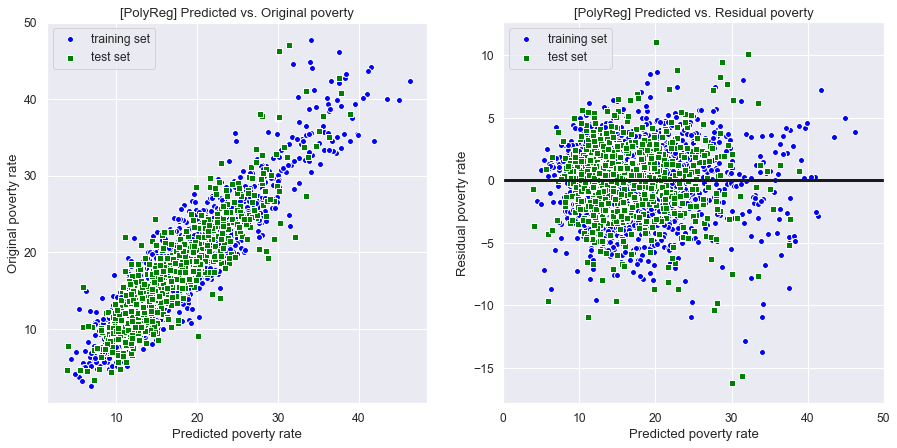

In [53]:
# Write a function: predicted vs. original plot
def plot_comp(y_train_pred, y_train,
             y_test_pred, y_test):
    plt.scatter(y_train_pred, y_train,
            c='blue', edgecolor='w',
            marker='o', label='training set')
    plt.scatter(y_test_pred, y_test,
            c='green', edgecolor='w',
            marker='s', label='test set')
    plt.xlabel('Predicted poverty rate')
    plt.ylabel('Original poverty rate')
    plt.legend(loc='upper left')

# Write a function: predicted vs. residual plot
def plot_resd(y_train_pred, y_train,
             y_test_pred, y_test):
    plt.scatter(y_train_pred, y_train_pred - y_train,
            c='blue', edgecolor='w',
            marker='o', label='training set')
    plt.scatter(y_test_pred, y_test_pred - y_test,
            c='green', edgecolor='w',
            marker='s', label='test set')
    plt.hlines(y=0, xmin=0, xmax=50, colors='k', lw=3)
    plt.xlim([0,50])
    plt.xlabel('Predicted poverty rate')
    plt.ylabel('Residual poverty rate')
    plt.legend(loc='upper left')
    
# PolyReg: predicted vs original plot    
###########################################################################
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.2)
plt.subplot(1,2,1)
plot_comp(y_train_pr_pred, y_train_act,
          y_test_pr_pred, y_test_act)
plt.title('[PolyReg] Predicted vs. Original poverty')

# PolyReg: predicted vs residual plot    
plt.subplot(1,2,2)
plot_resd(y_train_pr_pred, y_train_act,
          y_test_pr_pred, y_test_act)
plt.title('[PolyReg] Predicted vs. Residual poverty')
plt.show()
###########################################################################

### OLS Stats Model: Multi-Linear Regression ###

In [54]:
##############################################
# Test: statsmodel Multiple LinearRegression # 
##############################################
# Compute linear regression: health__pct_low_birthweight
lm = ols('poverty_rate ~ health__pct_low_birthweight', df2).fit()
print(lm.summary())

# Compute multi-linear regression: 3 features
lm_3 = ols('poverty_rate ~ health__pct_low_birthweight + demo__pct_adults_less_than_a_high_school_diploma + econ__pct_unemployment', df2).fit()
print(lm_3.summary())

# Compute multi-linear regression: 5 features
lm_5 = ols('poverty_rate ~ health__pct_low_birthweight + demo__pct_adults_less_than_a_high_school_diploma + econ__pct_unemployment + demo__pct_below_18_years_of_age + demo__pct_aged_65_years_and_older', df2).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:           poverty_rate   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     1208.
Date:                Tue, 18 Sep 2018   Prob (F-statistic):          4.20e-222
Time:                        13:26:02   Log-Likelihood:                -9255.7
No. Observations:                2950   AIC:                         1.852e+04
Df Residuals:                    2948   BIC:                         1.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### Summary: using OLS model to compare regression models ####
The aim of this section is to compare model performance across all 3 OLS models that we built. 1st model was built using only lowbirthweight. 2nd model was built using 3 predictors (i.e., low birthweight, less than high school, unemployment). Finally, 3rd model was built using 5 predictors (i.e., added age demographic features). 

Overall, the 3rd model provided the best adjusted R-squared value of 0.619 and the least AIC value of 1.669e+04 as well.

### OLS Stats Model: Scatter Plots ###

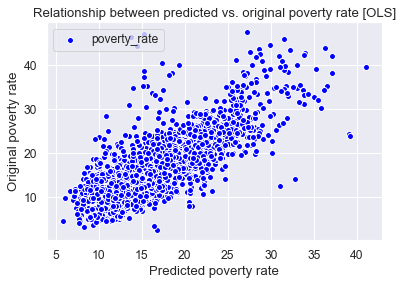

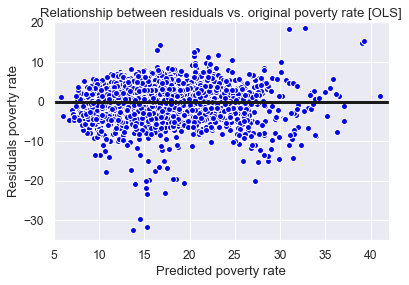

In [55]:
##############################
# Evaluation 0: Scatter Plot #
##############################
# Plot: Predicted vs original poverty_rate
plt.figure()
_ = plt.scatter(lm_5.fittedvalues, df2.poverty_rate,
            c='blue', edgecolor='w', marker='o')
_ = plt.title('Relationship between predicted vs. original poverty rate [OLS]')
_ = plt.xlabel('Predicted poverty rate')
_ = plt.ylabel('Original poverty rate')
_ = plt.legend(loc='upper left')
_ = plt.show()

###############################
# Evaluation 1: Residual Plot #
###############################
# Plot: Residuals vs. predicted poverty_rate
plt.figure()
_ = plt.scatter(lm_5.fittedvalues, lm_5.fittedvalues - df2.poverty_rate,
            c='blue', edgecolor='w', marker='o')
_ = plt.title('Relationship between residuals vs. original poverty rate [OLS]')
_ = plt.xlabel('Predicted poverty rate')
_ = plt.ylabel('Residuals poverty rate')
_ = plt.legend(loc='upper left')
_ = plt.hlines(y=0, xmin=5, xmax=42, colors='k', lw=3)
_ = plt.xlim([5,42])
_ = plt.ylim([-35,20])
_ = plt.show()

#### Summary: scatter plots of OLS models ####
First scatter plot showed that there were quite a lot of outliers present in lower and upper range of poverty rates.

Second scatter plot showed difference in original - predicted poverty rates. It showed more clear representation to presence of more outliers in lower and upper range of poverty rates with respect to predicted poverty rate.

### Model Assessment: with presence of outliers ###
* Plotting: sns.residuals, scipy quantile plot, sns.distribution, sm.influence_plot 

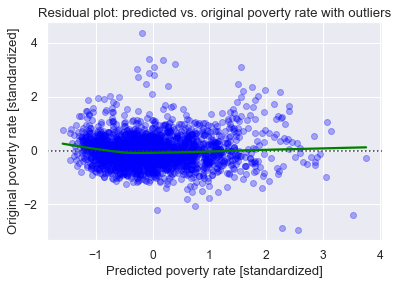

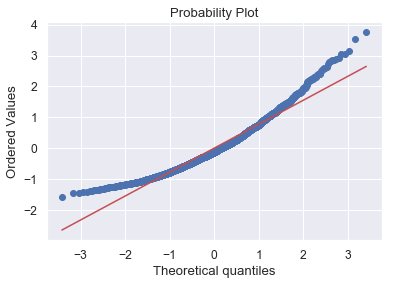

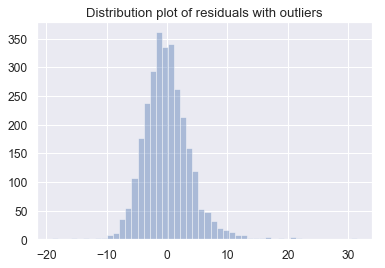

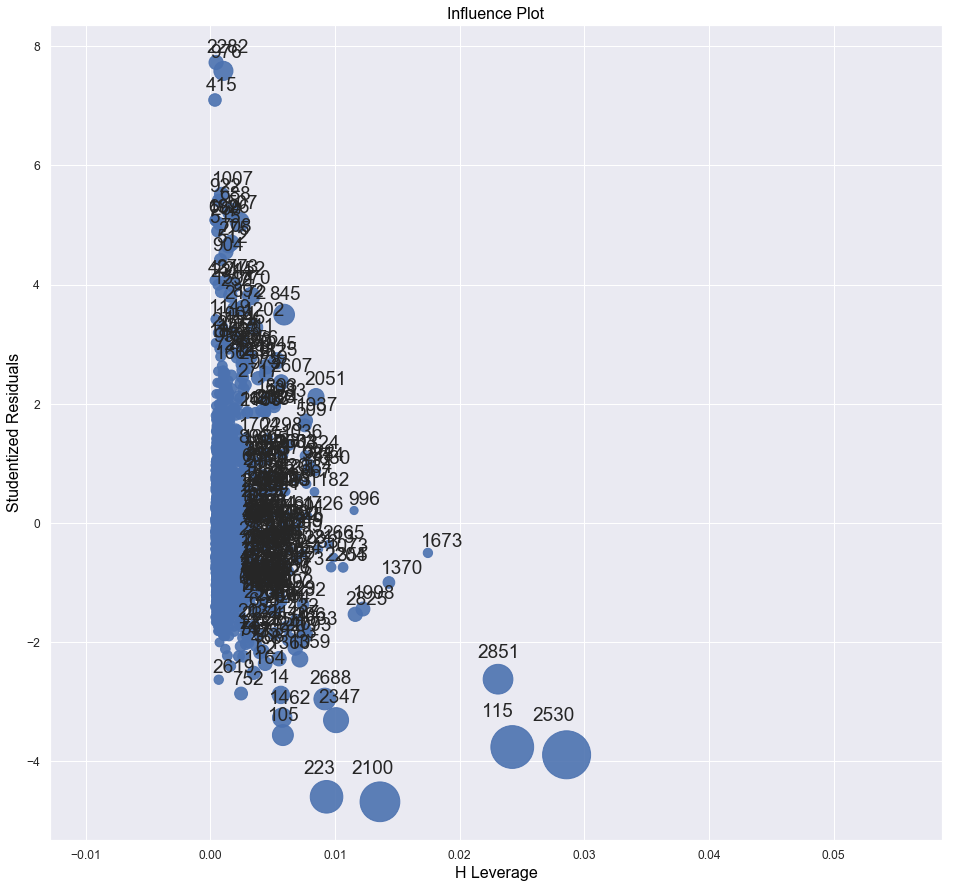

In [56]:
# Define input features: 3 predictors
X_train_std = sc_x.fit_transform(X_train[['health__pct_low_birthweight','demo__pct_adults_less_than_a_high_school_diploma','econ__pct_unemployment']])

# Fit LinReg():
lr = LinearRegression()
lr.fit(X_train_std, y_train_std)

# Plot: sns.residuals plot using LinReg model
plt.figure()
ax=sns.residplot(lr.predict(X_train_std), y_train_std, lowess=True,
                color='blue',scatter_kws={'alpha':0.3}, line_kws={'color':'green'})
plt.title('Residual plot: predicted vs. original poverty rate with outliers')
plt.xlabel('Predicted poverty rate [standardized]')
plt.ylabel('Original poverty rate [standardized]')
plt.show()

# Plot: quantile plot of residuals using LinReg model
plt.figure()
sp.probplot(lr.predict(X_train_std), dist='norm', plot=pylab)
pylab.show()

# Plot: distribution plot of residuals - 3 predictors with outliers
plt.figure()
plt.title('Distribution plot of residuals with outliers')
sns.distplot(lm_3.resid, kde=False)
plt.show()

# Plot: leverage plot to identify high leverage points in the model.
fig, ax = plt.subplots(figsize=(16,15))
fig = sm.graphics.influence_plot(lm_3,alpha=0.01,ax=ax,criterion="cooks",plot_alpha=0.9)
plt.show()

#### Summary: checking presence of outliers  ####
Plot 1: seaborn residual plot showed that there were quite number of residuals centralized in low to mid range of predicted poverty rate. Thus, it indicated the fact that model was doing relatively poor job than high poverty rate counties.

Plot 2: this probablisitc quantile plot provided a clue that distribution of residuals were quite noraml in mid range.
However, still low and high range of distribution were not aligned well with a straight linear regression fit.

Plot 3: this residual histogram did confirm that the distribution was quite normal with presence of some outliers on the lower and upper end of tails.

Plot 4: identified high leverage and some influence = index 2742 and low leverage and high influence data points = indexes 451, 1059 and etc.

In [57]:
# Filter and print rows with low and high leverage with influences:
# High leverage, some influence: 115, 2530, 2851
# Low leverage, high influence: 415, 876, 2282
df2[['health__pct_low_birthweight','demo__pct_adults_less_than_a_high_school_diploma','econ__pct_unemployment','poverty_rate']][df2.index.isin([115,415,976,2282,2530,2851])]

,health__pct_low_birthweight,demo__pct_adults_less_than_a_high_school_diploma,econ__pct_unemployment,poverty_rate
115,0.062000,0.333667,0.231,24.2
415,0.083114,0.128358,0.054,44.3
976,0.062000,0.180377,0.055,47.0
2282,0.071000,0.139581,0.053,46.3
2530,0.049000,0.340681,0.240,23.9
2851,0.232000,0.123370,0.038,14.1


** Interpretation:**
The model was constructed using three features % low birthweight, % no high school diploma and % unemployment rate. There are presence of outliers due to somewhat outstanding value occurred in these three features.

Here are some examples of interpreted outliers:
* 2851: high % of low birthweight and low % of unemployment rate but relatively lower poverty rate as an outlier.
* 2530: higher % of no high school diploma and unemployment rate indicated middle poverty rate
* 415 & 976: low % of unemployment rate and no high school diploma but these standout as exceptions with higher poverty rate.

### Model Assessment: without outliers ###
* Plotting: sns.residuals, scipy quantile plot, sns.distribution, sm.influence_plot 

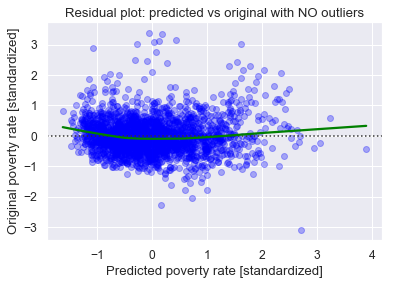

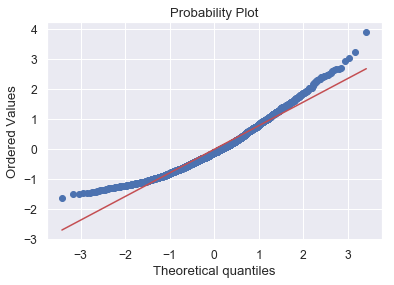

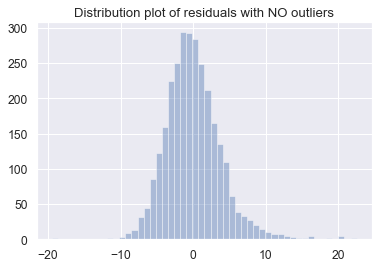

In [58]:
## Remove Outliers ##
df_cleaned = df2.drop(df2.index[[115,415,976,2282,2530,2851]])
X_new, y_new = df_cleaned.drop(['poverty_rate'], axis=1), df_cleaned['poverty_rate']

# Data Partition: cleansed dataframe with outliers removal
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y_new,
                                                   test_size=1/4, random_state=123)
y_train_new_std = sc_y.fit_transform(y_train_new[:,np.newaxis]).flatten()
y_test_new_std = sc_y.fit_transform(y_test_new[:,np.newaxis]).flatten()

# Statsmodel ols: post outliers removal
lr_ols_cleaned = ols('poverty_rate ~ health__pct_low_birthweight + demo__pct_adults_less_than_a_high_school_diploma + econ__pct_unemployment',df_cleaned).fit()
print(lr_ols_cleaned)

# Define input features: 3 predictors - post outliers removal
X_train_new_std = sc_x.fit_transform(X_train_new[['health__pct_low_birthweight','demo__pct_adults_less_than_a_high_school_diploma','econ__pct_unemployment']])

# Re-fit: LinearRegression
lr_cleaned = LinearRegression()
lr_cleaned.fit(X_train_new_std, y_train_new_std)

# Plot: sns.residuals plot [post outliers removal]
plt.figure()
ax = sns.residplot(lr_cleaned.predict(X_train_new_std), y_train_new_std, lowess=True,
                  color='blue',scatter_kws={'alpha':0.3},line_kws={'color':'green'})
plt.title('Residual plot: predicted vs original with NO outliers')
plt.xlabel('Predicted poverty rate [standardized]')
plt.ylabel('Original poverty rate [standardized]')
plt.show()

# Plot: quantile plot of residuals [post outliers removal]
plt.figure()
sp.probplot(lr_cleaned.predict(X_train_new_std), dist="norm", plot=pylab)
pylab.show()

# Plot: distribution plot of residuals - 3 predictors with NO outliers
plt.figure()
plt.title('Distribution plot of residuals with NO outliers')
sns.distplot(lr_ols_cleaned.resid, kde=False)
plt.show()


 ** Summary: post outliers removal **

Plot 1: seaborn residual plot showed that there were still quite number of residuals centralized in low and high range of predicted poverty rate. 

Plot 2: this probablisitc quantile plot provided a clue that distribution of residuals were quite normal in mid range.
However, still low and high range of poverty rates were not perfectly aligned with a linear regression fit.

Plot 3: this residual histogram did confirm a normal distribution shape due to removal of outliers. However, still outliers are present and showing near the upper end of tails.